In [2]:
import pandas as pd
import numpy as np
import scipy as sc
from scipy.stats import ttest_ind, shapiro, mannwhitneyu, probplot, levene
import pylab
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [3]:
df_features = pd.read_csv('mice_behavior_capstone/process_data/results/all_the_data.csv')

#Strings to not be considered
arms= ['CL', 'CR', 'OT', 'OB', 'M', 'F1', 'F2', 'F3', 'F4', 'bottom', 'count', '_num_']

In [4]:
#Considers only these features
cols_main= [col for col in df_features.columns if not any(arm in col for arm in arms)]
# cols_main_final = [e for e in cols_main if e not in ('Unnamed: 0', 'inner_directory', 'mouse_details_date', 'mouse_details_mouseID',
#                                               'mouse_details_time',)]

In [5]:
# final_features= [col for col in df_features_final.columns if col not in ('mouse_details_sex', 'mouse_details_strain')]

In [6]:
# In velocity, only active speed considered as closed speed influenced by another features: fraction rest!

final_features= ['fraction_in_arms_closed', 'fraction_in_arms_middle', 'fraction_in_arms_open',
               'mouse_length',
               'peeking_average_length_total', 'peeking_fraction_total', 'peeking_median_length_total',
               'rest_fraction_all_arms', 'rest_fraction_closed_arms', 'rest_fraction_open_arms',
               'safety_and_rest_fraction_closed_arms', 'safety_fraction_closed_arms',
#  'total_distance_closed',
#  'total_distance_open',
               'turning_preferences_fraction_back', 'turning_preferences_fraction_left', 
               'turning_preferences_fraction_right', 'turning_preferences_fraction_straight',
#  'turning_preferences_fraction_back_into_closed',
#  'turning_preferences_fraction_back_into_open',
#  'turning_preferences_fraction_back_only_straight_back',
#  'turning_preferences_fraction_back_only_straight_back_into_closed',
#  'turning_preferences_fraction_back_only_straight_back_into_open',
#  'turning_preferences_fraction_left_into_closed',
#  'turning_preferences_fraction_left_into_open',
#  'turning_preferences_fraction_left_only_right_left',
#  'turning_preferences_fraction_left_only_right_left_into_closed',
#  'turning_preferences_fraction_left_only_right_left_into_open',
#  'turning_preferences_fraction_right_into_closed',
#  'turning_preferences_fraction_right_into_open',
#  'turning_preferences_fraction_right_only_right_left',
#  'turning_preferences_fraction_right_only_right_left_into_closed',
#  'turning_preferences_fraction_right_only_right_left_into_open',
#  'turning_preferences_fraction_straight_into_closed',
#  'turning_preferences_fraction_straight_into_open',
#  'turning_preferences_fraction_straight_only_straight_back',
#  'turning_preferences_fraction_straight_only_straight_back_into_closed',
#  'turning_preferences_fraction_straight_only_straight_back_into_open',
# 'velocity_closed_towards_middle_average_speed',
 'velocity_closed_towards_middle_average_speed_active',
#  'velocity_closed_towards_middle_median_speed',
 'velocity_closed_towards_middle_median_speed_active',
#  'velocity_closed_towards_outside_average_speed',
 'velocity_closed_towards_outside_average_speed_active',
#  'velocity_closed_towards_outside_median_speed',
 'velocity_closed_towards_outside_median_speed_active',
#  'velocity_open_towards_middle_average_speed',
 'velocity_open_towards_middle_average_speed_active',
#  'velocity_open_towards_middle_median_speed',
 'velocity_open_towards_middle_median_speed_active',
#  'velocity_open_towards_outside_average_speed',
 'velocity_open_towards_outside_average_speed_active',
#  'velocity_open_towards_outside_median_speed',
 'velocity_open_towards_outside_median_speed_active']

In [21]:
df_bwpo = df_features.loc[(df_features['mouse_details_strain'].isin(['BW', 'PO'])) &
                          (df_features['mouse_details_sex'].isin(['M', 'F'])), :]

In [22]:
df_bwpo.rename(columns = {'fraction_in_arms_open-arms':'fraction_in_arms_open'}, inplace = True)

/Users/srinidhi/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [92]:
def one_factor_significance(df, features, alpha_normal=0.05, alpha_significance=0.05):

    ''' significance(df, features, alpha_normal=0.05, alpha_significance=0.05)
    Input: DataFrame of aggregated mice features, features, alpha levels
    Output: Normality_results, Feature significance, p-values'''
    
    #Initiate empty lists for results
    normal = [] #Boolean
    normality_p = [] #Tuple of normality test results
    stats_test_p = [] #P values
    significance = [] #Boolean, for significance
    
    for feature in features:

        species1= df.loc[(df['mouse_details_strain']=='BW')&(df[feature]!=0), feature].dropna()
        species2= df.loc[(df['mouse_details_strain']=='PO')&(df[feature]!=0), feature].dropna()

        #Do a Normality test and store p value
        norm1 = shapiro(species1)[1]
        norm2 = shapiro(species2)[1]
        
        #If not normal, do a log transformation
        if min(norm1, norm2) < alpha_normal:
            
            #Check if log tranformation makes data more normal
            if min(shapiro(np.log(species1))[1], shapiro(np.log(species2))[1])> min(norm1, norm2):
                
                print(feature +" -Log done")
                species1= np.log(species1)
                species2= np.log(species2)

                norm1 = shapiro(species1)[1]
                norm2 = shapiro(species2)[1]
        
        normality_p.append((norm1, norm2))
        
        #Conduct a t-test if both distributions are probably sampled from a N(mu, sigma)
        if min(norm1, norm2) > alpha_normal:
            
            normal.append(True)
            
            #Do a t-test(or Anova)
            p = ttest_ind(species1, species2, equal_var= False)[1]
            stats_test_p.append(p)

            if p<alpha_significance: 
                significance.append(True)
            else: 
                significance.append(False)
        
        #Else, perform a non-parametric test - ideally, not performed if outliers are removed
        else:
            species1= df.loc[(df['mouse_details_strain']=='BW')&(df[feature]!=0), feature].dropna()
            species2= df.loc[(df['mouse_details_strain']=='PO')&(df[feature]!=0), feature].dropna()
            
            normal.append(False)
            p = mannwhitneyu(species1, species2)[1]
            stats_test_p.append(p)
            
            if p<alpha_significance: 
                significance.append(True)
            else: 
                significance.append(False)

    return normal, normality_p, significance, stats_test_p

In [170]:
def significance_mann(df, features, alpha_normal=0.05, alpha_significance=0.05):

    ''' significance(df, features, alpha_normal=0.05, alpha_significance=0.05)
    Input: DataFrame of aggregated mice features, features, alpha levels
    Output: p-values for non parametric test (only for non normal features)'''
    
    stats_test_p = []
    for feature in features: 
         #P values
        species1= df.loc[(df['mouse_details_strain']=='BW')&(df[feature]!=0), feature].dropna()
        species2= df.loc[(df['mouse_details_strain']=='PO')&(df[feature]!=0), feature].dropna()
        p = mannwhitneyu(species1, species2)[1]
        stats_test_p.append(p)
    
    return stats_test_p

In [174]:
def one_factor_significance_sex(df, features, alpha_normal=0.05, alpha_significance=0.05):

    ''' significance(df, features, alpha_normal=0.05, alpha_significance=0.05)
    Input: DataFrame of aggregated mice features, features, alpha levels
    Output: Normality_results, Feature significance, p-values'''
    
    #Initiate empty lists for results
    normal = [] #Boolean
    normality_p = [] #Tuple of normality test results
    stats_test_p = [] #P values
    significance = [] #Boolean, for significance
    
    for feature in features:

        species1= df.loc[(df['mouse_details_sex']=='M')&(df[feature]!=0), feature].dropna()
        species2= df.loc[(df['mouse_details_sex']=='F')&(df[feature]!=0), feature].dropna()

        #Do a Normality test and store p value
        norm1 = shapiro(species1)[1]
        norm2 = shapiro(species2)[1]
        
        #If not normal, do a log transformation
        if min(norm1, norm2) < alpha_normal:
            
            #Check if log tranformation makes data more normal
            if min(shapiro(np.log(species1))[1], shapiro(np.log(species2))[1])> min(norm1, norm2):
                
                print(feature +" -Log done")
                species1= np.log(species1)
                species2= np.log(species2)

                norm1 = shapiro(species1)[1]
                norm2 = shapiro(species2)[1]
        
        normality_p.append((norm1, norm2))
        
        #Conduct a t-test if both distributions are probably sampled from a N(mu, sigma)
        if min(norm1, norm2) > alpha_normal:
            
            normal.append(True)
            
            #Do a t-test(or Anova)
            p = ttest_ind(species1, species2, equal_var= False)[1]
            stats_test_p.append(p)

            if p<alpha_significance: 
                significance.append(True)
            else: 
                significance.append(False)
        
        #Else, perform a non-parametric test - ideally, not performed if outliers are removed
        else:
            species1= df.loc[(df['mouse_details_sex']=='M')&(df[feature]!=0), feature].dropna()
            species2= df.loc[(df['mouse_details_sex']=='F')&(df[feature]!=0), feature].dropna()
            
            normal.append(False)
            p = mannwhitneyu(species1, species2)[1]
            stats_test_p.append(p)
            
            if p<alpha_significance: 
                significance.append(True)
            else: 
                significance.append(False)

    return normal, normality_p, significance, stats_test_p

In [175]:
normal_sex, normality_p_sex, significance_sex, stats_test_p_sex = one_factor_significance_sex(df_bwpo, features=final_features)

peeking_average_length_total -Log done
peeking_fraction_total -Log done
peeking_median_length_total -Log done
turning_preferences_fraction_back -Log done
turning_preferences_fraction_left -Log done
turning_preferences_fraction_straight -Log done
velocity_closed_towards_middle_average_speed_active -Log done
velocity_closed_towards_middle_median_speed_active -Log done
velocity_closed_towards_outside_average_speed_active -Log done
velocity_closed_towards_outside_median_speed_active -Log done
velocity_open_towards_middle_average_speed_active -Log done
velocity_open_towards_middle_median_speed_active -Log done
velocity_open_towards_outside_average_speed_active -Log done
velocity_open_towards_outside_median_speed_active -Log done


In [171]:
stats_mann_sex= significance_mann(df_bwpo, features=final_features)

In [93]:
normal, normality_p, significance, stats_test_p= one_factor_significance(df_bwpo, features=final_features)

fraction_in_arms_open -Log done
peeking_average_length_total -Log done
peeking_fraction_total -Log done
peeking_median_length_total -Log done
turning_preferences_fraction_back -Log done
turning_preferences_fraction_left -Log done
velocity_closed_towards_middle_average_speed_active -Log done
velocity_closed_towards_middle_median_speed_active -Log done
velocity_closed_towards_outside_average_speed_active -Log done
velocity_closed_towards_outside_median_speed_active -Log done
velocity_open_towards_middle_average_speed_active -Log done
velocity_open_towards_middle_median_speed_active -Log done
velocity_open_towards_outside_average_speed_active -Log done
velocity_open_towards_outside_median_speed_active -Log done


## Results

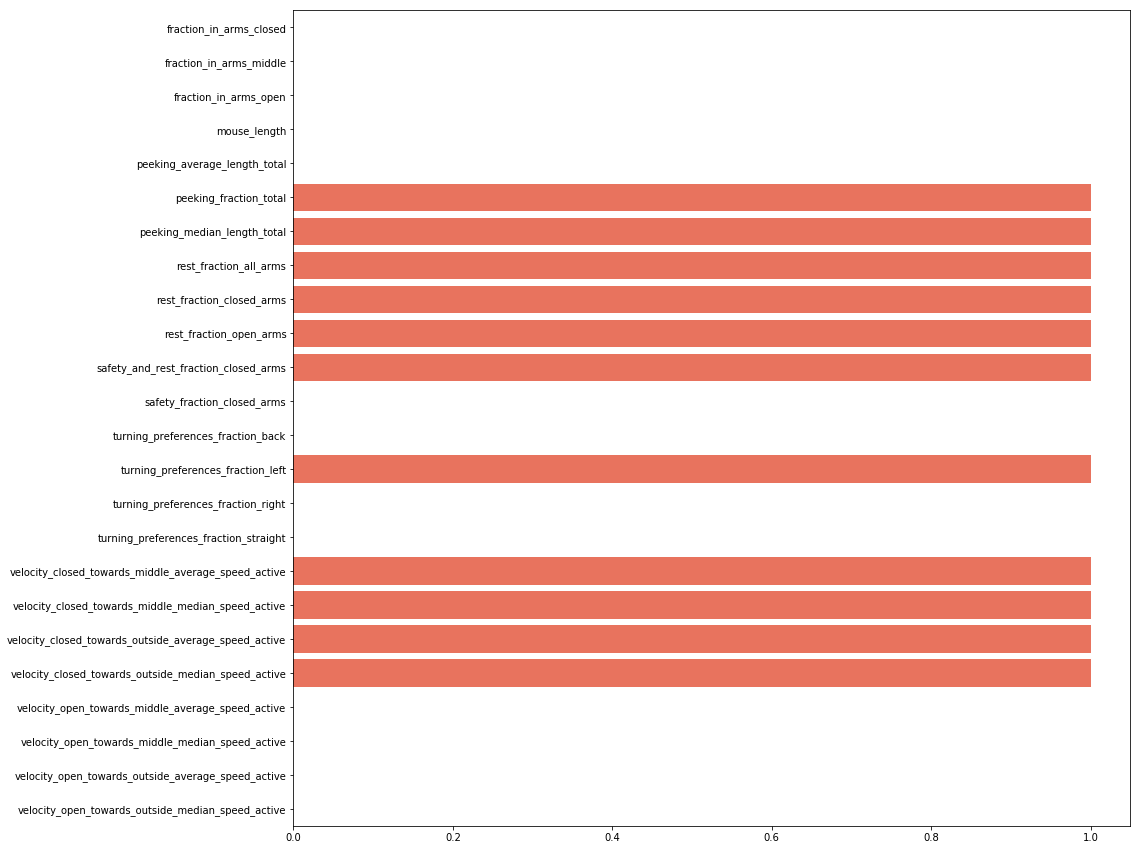

In [94]:
plt.figure(figsize=(15, 15))
sns.barplot(x= normal, y= final_features, color='tomato')
plt.title("")

plt.show()

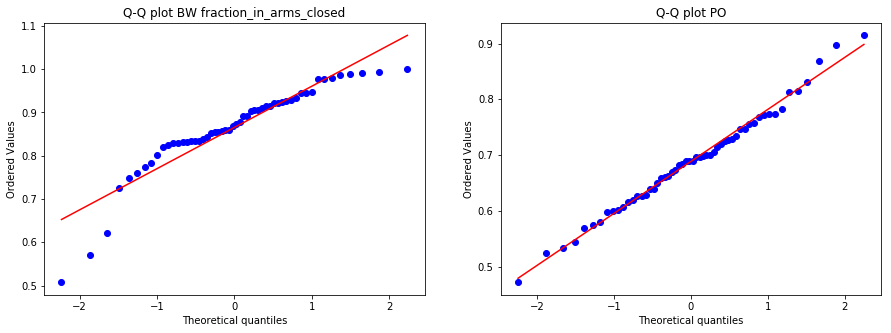

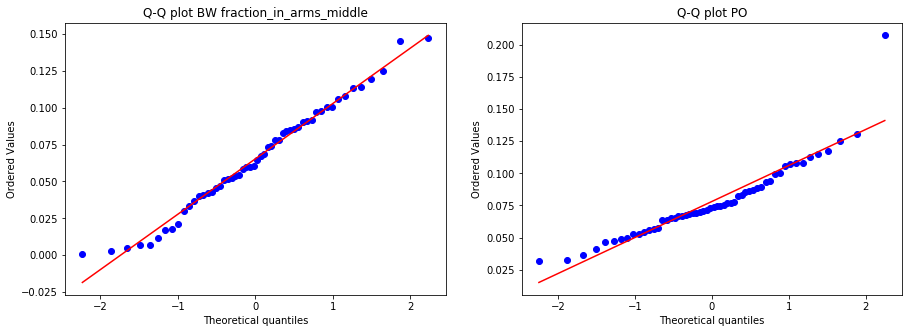

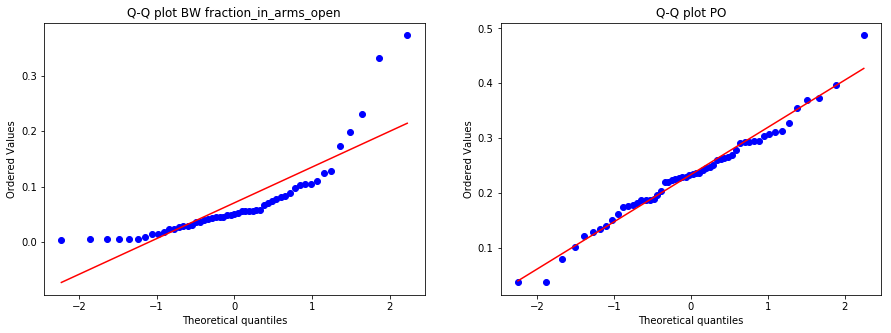

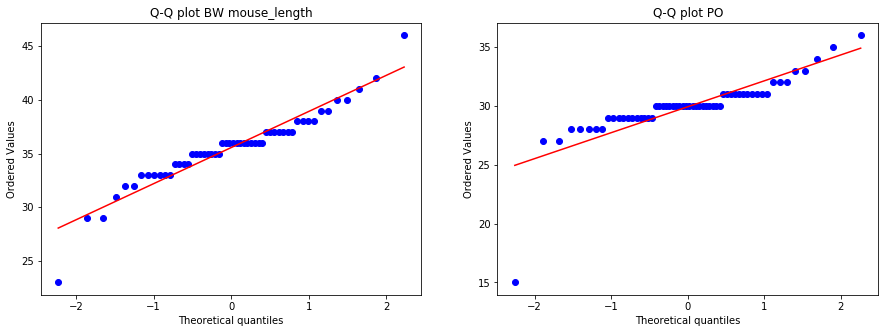

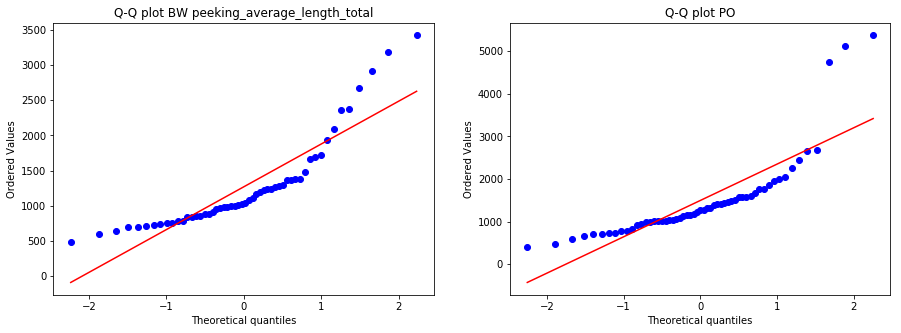

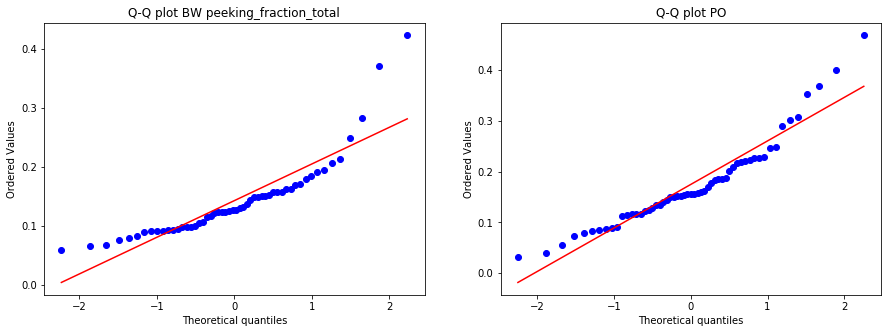

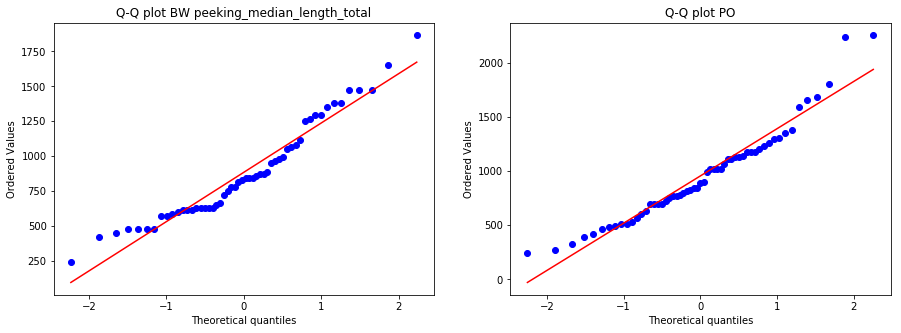

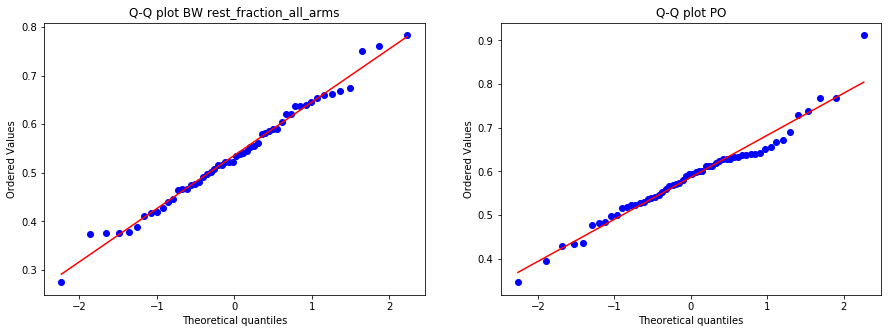

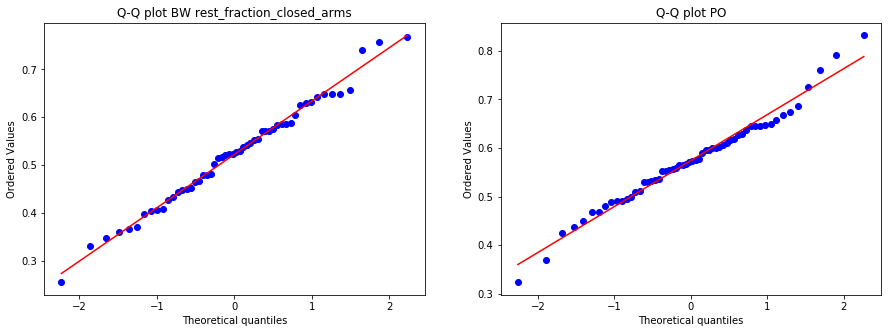

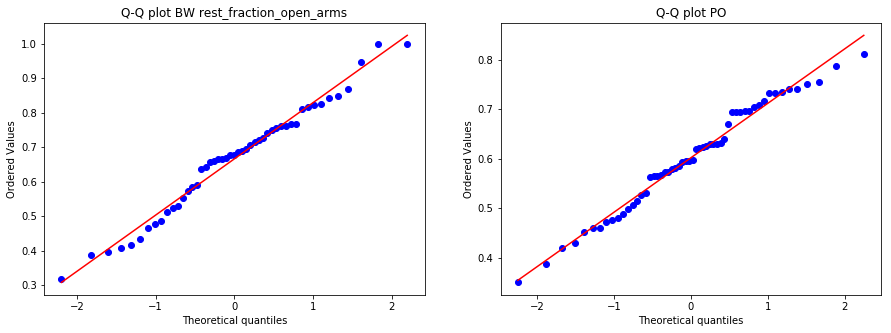

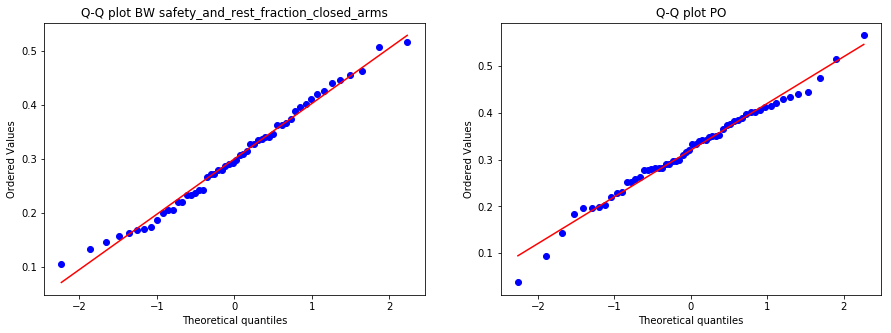

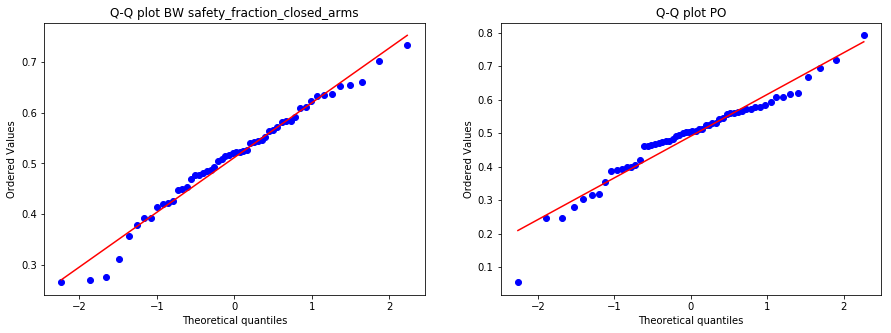

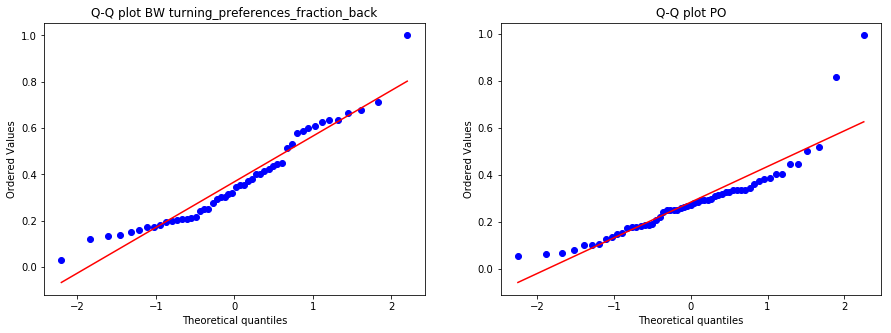

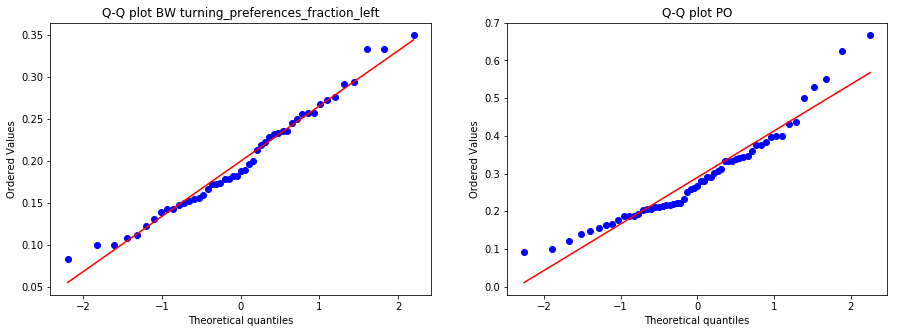

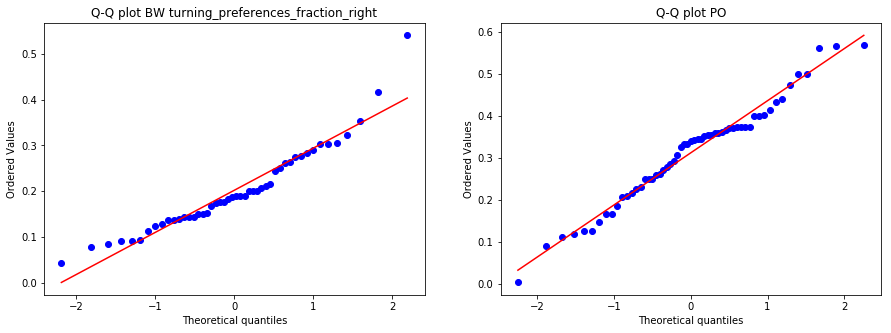

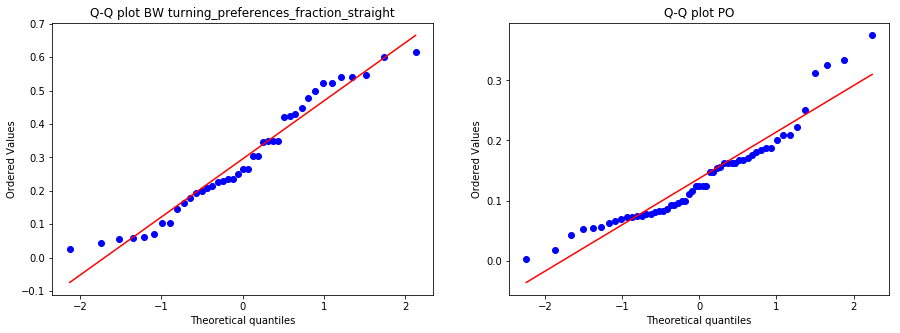

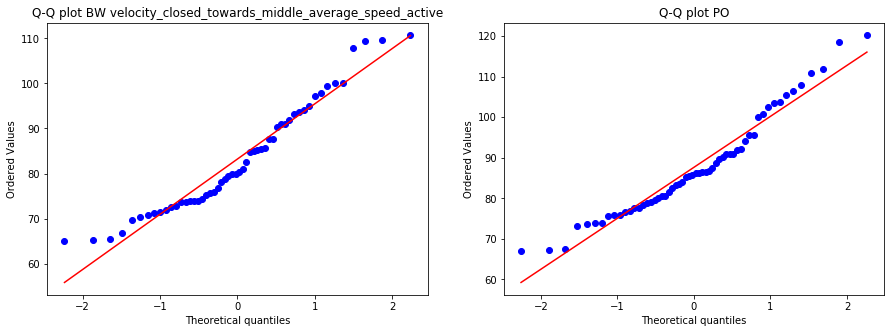

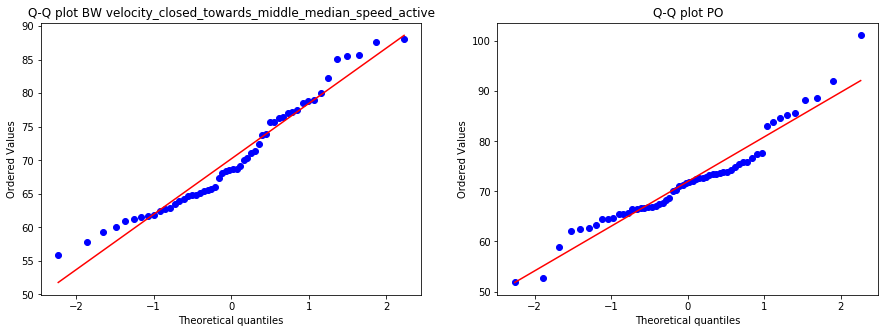

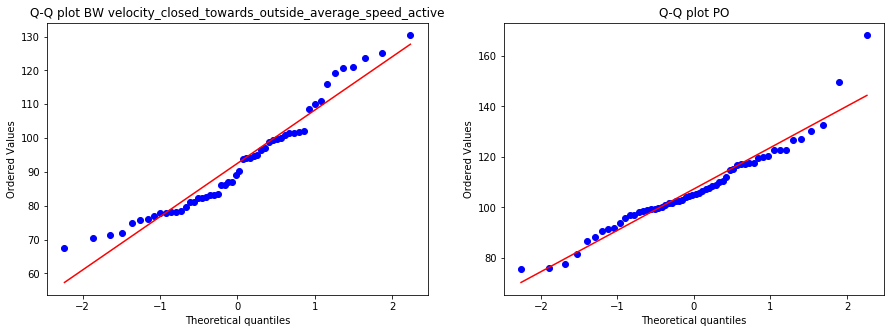

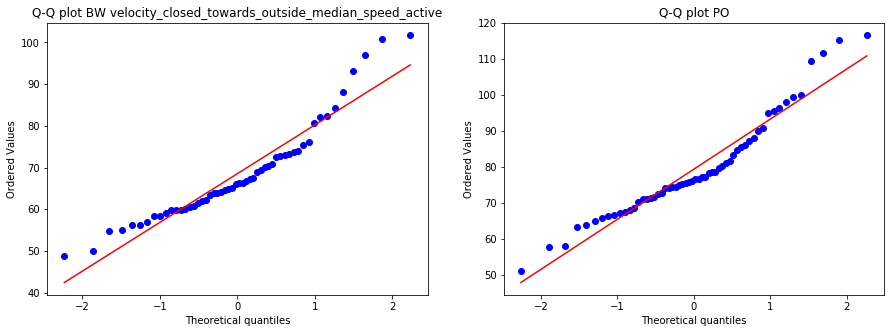

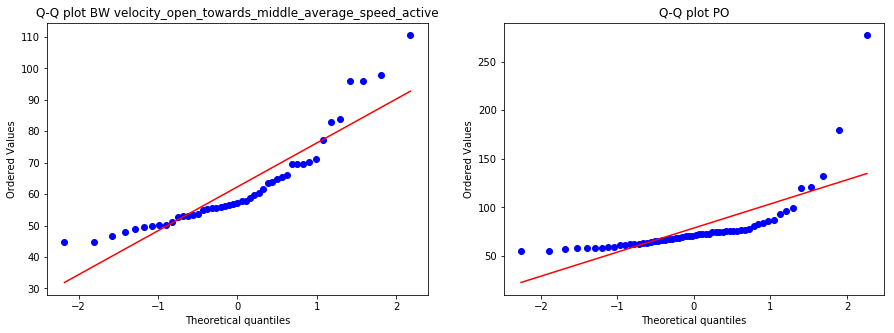

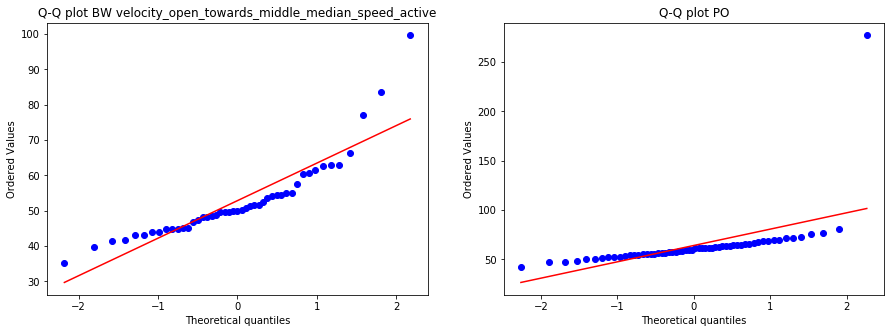

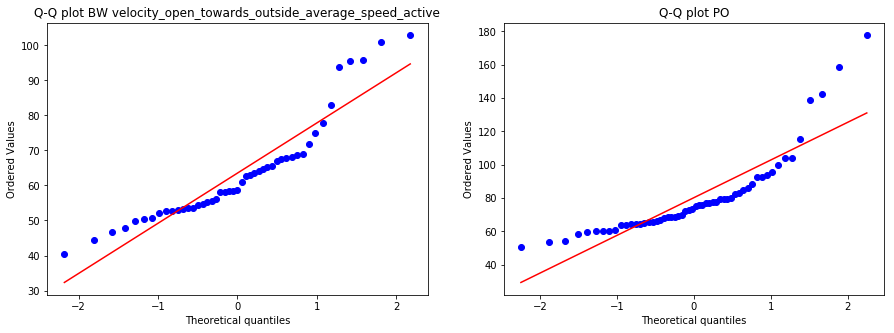

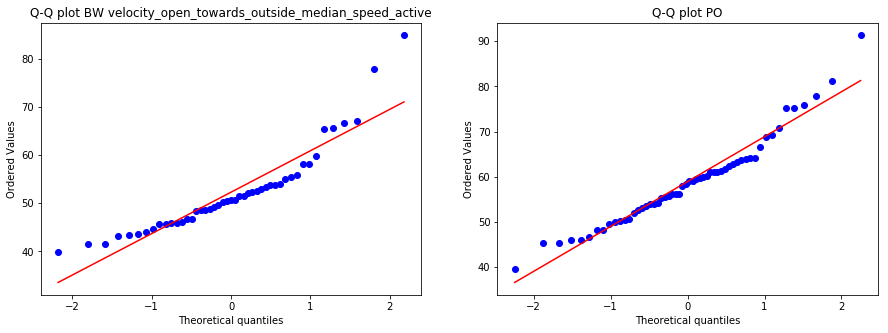

In [50]:
# All Q-Q plots

for feature in final_features:

    plt.subplots(1, 2, figsize=(15, 5))

    plt.subplot(1, 2, 1)
    probplot(df_bwpo.loc[(df_bwpo['mouse_details_strain']=='BW')&(df_bwpo[feature]!=0), feature].dropna(), dist="norm", plot=pylab)
    plt.title("Q-Q plot BW "+ feature)

    plt.subplot(1, 2, 2)
    probplot(df_bwpo.loc[(df_bwpo['mouse_details_strain']=='PO')&(df_bwpo[feature]!=0), feature].dropna(), dist="norm", plot=pylab)
    plt.title("Q-Q plot PO")
             
    plt.show()

In [51]:
normality_p

[(5.881685865460895e-05, 0.9658530950546265),
 (0.5112619996070862, 0.00011232830729568377),
 (0.0234952624887228, 3.5107175335724605e-06),
 (0.0030765996780246496, 1.5723051749461092e-09),
 (0.03227872774004936, 0.056877993047237396),
 (0.19577477872371674, 0.16708621382713318),
 (0.34714218974113464, 0.405650794506073),
 (0.890041172504425, 0.15651540458202362),
 (0.9168432354927063, 0.6281934976577759),
 (0.4984835088253021, 0.439205139875412),
 (0.6944689750671387, 0.8522692918777466),
 (0.4188374876976013, 0.031232362613081932),
 (0.017395777627825737, 0.025632426142692566),
 (0.589037299156189, 0.8785815238952637),
 (0.004915708210319281, 0.4003899097442627),
 (0.07544123381376266, 0.0013864595675840974),
 (0.0655960738658905, 0.22641192376613617),
 (0.1382678896188736, 0.10703759640455246),
 (0.12854015827178955, 0.26284971833229065),
 (0.06794632226228714, 0.25235530734062195),
 (0.0021549949888139963, 1.9222232694460217e-08),
 (0.004527068231254816, 7.402626428509862e-11),
 (0

In [165]:
stats_test_p

[1.072878093178137e-13,
 0.04226554072193055,
 2.2620438358259447e-14,
 2.022015127557377e-15,
 0.049569785717938505,
 0.06898827390554842,
 0.5576296895036396,
 0.009882628805418731,
 0.00844590980744413,
 0.020319725117125903,
 0.28349095268776153,
 0.18415579290807949,
 0.01189172882407318,
 1.7181299625167867e-05,
 7.230163063676707e-07,
 1.3243572883569393e-06,
 0.05221447642765974,
 0.2900247538017156,
 1.8823868699210982e-06,
 9.106499415975611e-06,
 9.722675122557064e-07,
 4.0467250618097004e-07,
 2.5743408403727635e-06,
 5.90161735276484e-05]

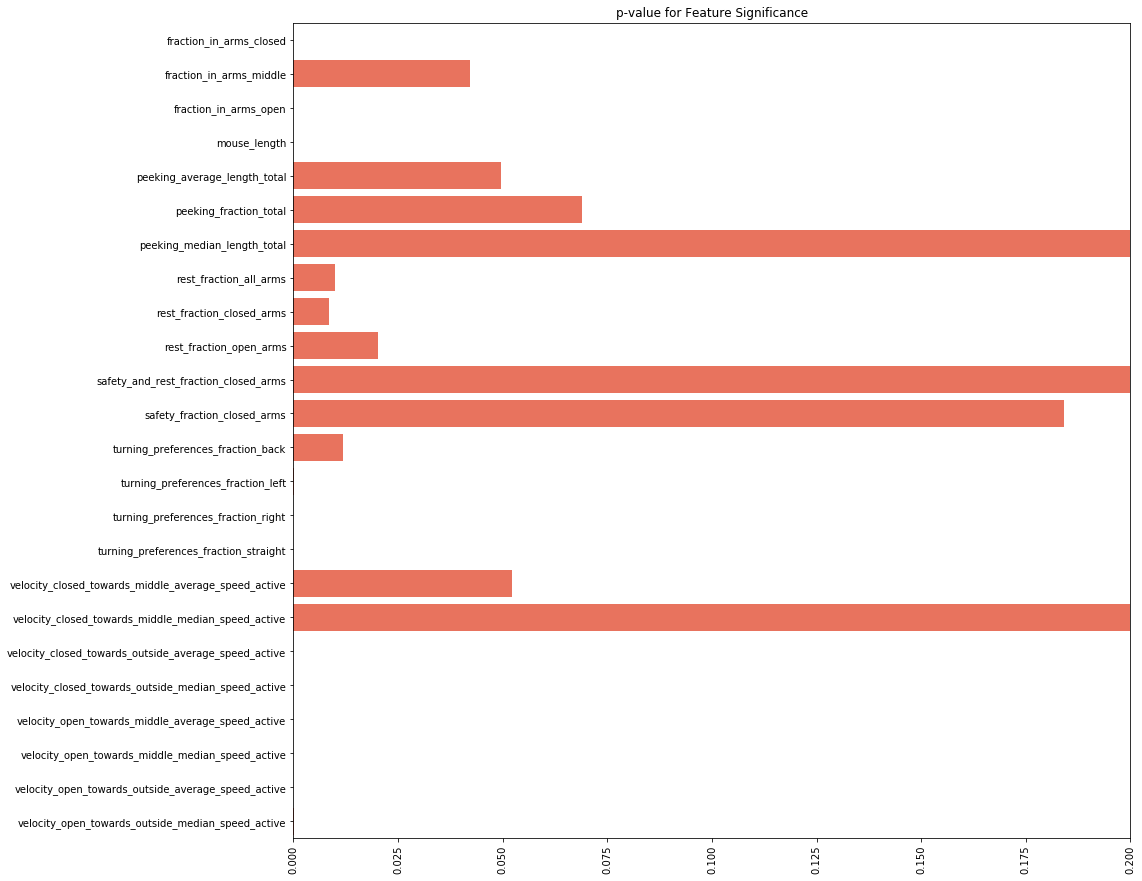

In [95]:
plt.figure(figsize=(15, 15))
plt.title("p-value for Feature Significance")
sns.barplot(x=stats_test_p, y=final_features, color='tomato')
plt.xticks(rotation= 90)
plt.xlim(0,0.2)
plt.show()

In [80]:
np.array(final_features)[np.array(stats_test_p)<0.05]

array(['fraction_in_arms_closed', 'fraction_in_arms_middle',
       'fraction_in_arms_open', 'mouse_length',
       'peeking_average_length_total', 'peeking_fraction_total',
       'peeking_median_length_total', 'rest_fraction_all_arms',
       'rest_fraction_closed_arms', 'rest_fraction_open_arms',
       'safety_and_rest_fraction_closed_arms',
       'safety_fraction_closed_arms', 'turning_preferences_fraction_back',
       'turning_preferences_fraction_left',
       'turning_preferences_fraction_right',
       'turning_preferences_fraction_straight',
       'velocity_closed_towards_middle_average_speed_active',
       'velocity_closed_towards_middle_median_speed_active',
       'velocity_closed_towards_outside_average_speed_active',
       'velocity_closed_towards_outside_median_speed_active',
       'velocity_open_towards_middle_average_speed_active',
       'velocity_open_towards_middle_median_speed_active',
       'velocity_open_towards_outside_average_speed_active',
       'velo

1. Mouse length
2. Fraction of time(Open arms, Closed arms, Middle)
3. Turn Preference(Left, Right, Straight, Back)
4. Rest Fraction(Close Arms, Open Arms, All Arms)
5. Active_Velocities(Close->Outside, Open->Outside, Open->back)

## Example where Log transformation works

In [10]:
df_features_final= df_features.dropna()

In [ ]:
df_bwpo['velocity_open_towards_middle_median_speed_active']

## Outlier Effect

In [87]:
#p-values of normality test (higher the p value, higher is the probability of the underlying distribution being Normal)
print(shapiro(df_bwpo.loc[df_bwpo['mouse_details_strain']=='PO', 'velocity_open_towards_middle_median_speed_active'])[1])
print(shapiro(sorted(df_bwpo.loc[df_bwpo['mouse_details_strain']=='PO', 'velocity_open_towards_middle_median_speed_active'])[:-1])[1])

7.622576547283537e-15
0.9803978800773621


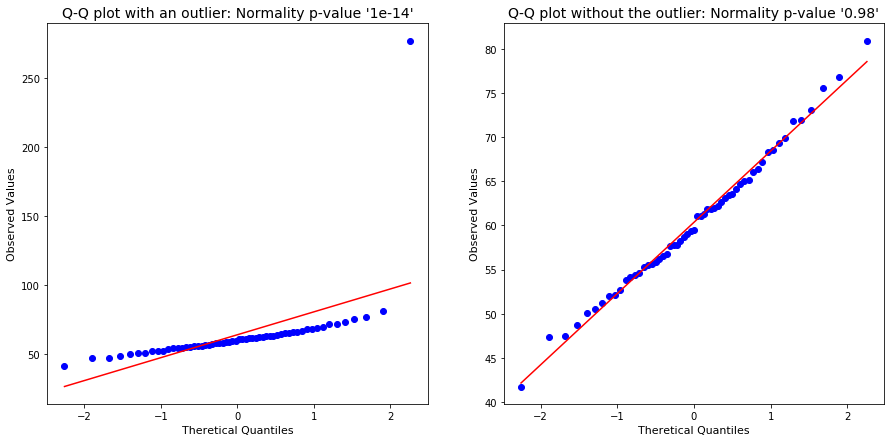

In [121]:
plt.subplots(1, 2, figsize=(15, 7))

plt.subplot(1, 2, 1)
probplot(df_bwpo.loc[df_bwpo['mouse_details_strain']=='PO', 'velocity_open_towards_middle_median_speed_active'], dist="norm", plot=pylab)
plt.title("Q-Q plot with an outlier: Normality p-value '1e-14'", fontsize=14)
plt.xlabel('Theretical Quantiles', fontsize=11)
plt.ylabel('Observed Values', fontsize=11)

plt.subplot(1, 2, 2)
probplot(sorted(df_bwpo.loc[df_bwpo['mouse_details_strain']=='PO', 'velocity_open_towards_middle_median_speed_active'])[:-1], dist="norm", plot=pylab)
plt.title("Q-Q plot without the outlier: Normality p-value '0.98'", fontsize=14)
plt.xlabel('Theretical Quantiles', fontsize=11)
plt.ylabel('Observed Values' ,fontsize=11)

plt.show()

In [127]:
#p-values of normality test (higher the p value, higher is the probability of the underlying distribution being Normal)
print(shapiro(df_bwpo.loc[(df_bwpo['mouse_details_strain']=='BW') & 
                         (df_bwpo['peeking_fraction_total']!=0), 'peeking_fraction_total'])[1])
print(shapiro(np.log(df_bwpo.loc[(df_bwpo['mouse_details_strain']=='BW') & 
                         (df_bwpo['peeking_fraction_total']!=0), 'peeking_fraction_total']))[1])

5.000780447517172e-07
0.19577477872371674


/Users/srinidhi/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


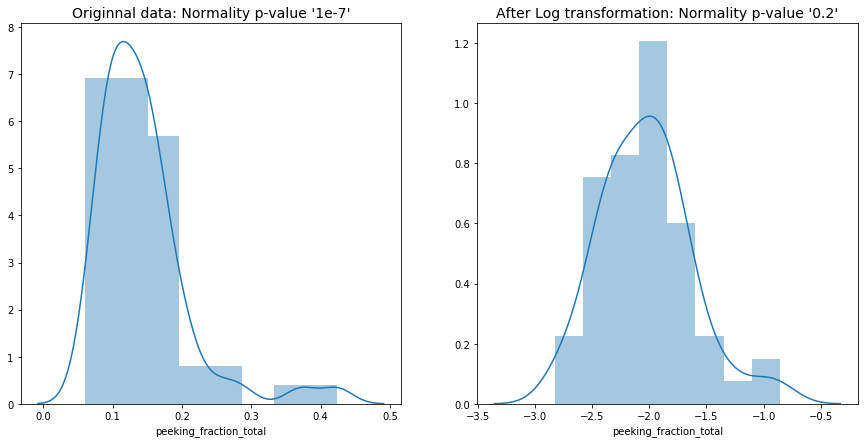

In [130]:
# Not Normal
plt.subplots(1, 2, figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.title("Originnal data: Normality p-value '1e-7'", fontsize=14)
sns.distplot(df_bwpo.loc[(df_bwpo['mouse_details_strain']=='BW') & 
                         (df_bwpo['peeking_fraction_total']!=0), 'peeking_fraction_total'], bins=8)

# Mostly Normal
plt.subplot(1, 2, 2)
plt.title("After Log transformation: Normality p-value '0.2'", fontsize=14)
sns.distplot(np.log(df_bwpo.loc[(df_bwpo['mouse_details_strain']=='BW') & 
                         (df_bwpo['peeking_fraction_total']!=0), 'peeking_fraction_total']), bins=8)
plt.show()

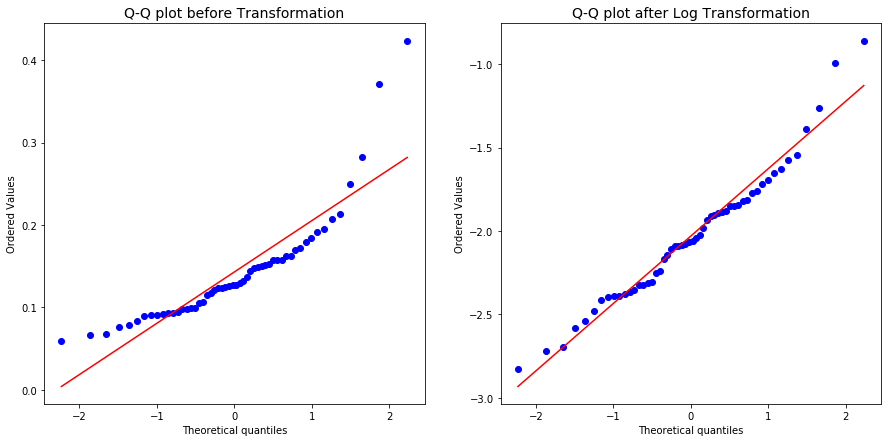

In [131]:
plt.subplots(1, 2, figsize=(15, 7))

plt.subplot(1, 2, 1)
probplot(df_bwpo.loc[(df_bwpo['mouse_details_strain']=='BW') & 
                         (df_bwpo['peeking_fraction_total']!=0), 'peeking_fraction_total'], dist="norm", plot=pylab)
plt.title("Q-Q plot before Transformation", fontsize=14)

plt.subplot(1, 2, 2)
probplot(np.log(df_bwpo.loc[(df_bwpo['mouse_details_strain']=='BW') & 
                         (df_bwpo['peeking_fraction_total']!=0), 'peeking_fraction_total']), dist="norm", plot=pylab)
plt.title("Q-Q plot after Log Transformation", fontsize=14)

plt.show()

## Negative effect of outliers 
- Log transformation won't work as Shapiro wilk test is very sensitive

In [24]:
#p-values of normality test (higher the p value, higher is the probability of the underlying distribution being Normal)
print(shapiro(df_features_final.loc[df_features_final['mouse_details_strain']=='PO', 'velocity_open_towards_middle_average_speed_active'])[1])
print(shapiro(np.log(df_features_final.loc[df_features_final['mouse_details_strain']=='PO', 'velocity_open_towards_middle_average_speed_active']))[1])

9.785273505258374e-06
0.0027029169723391533


/Users/srinidhi/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


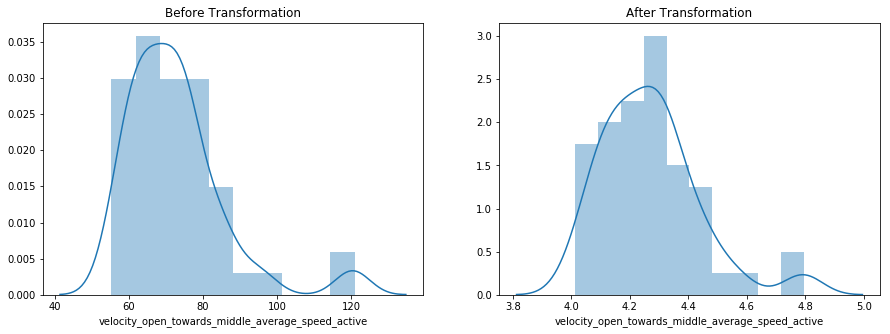

In [25]:
# Not Normal
plt.subplots(1, 2, figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title("Before Transformation")
sns.distplot(df_features_final.loc[df_features_final['mouse_details_strain']=='PO', 'velocity_open_towards_middle_average_speed_active'], bins=10)

# Mostly Normal
plt.subplot(1, 2, 2)
plt.title("After Transformation")
sns.distplot(np.log(df_features_final.loc[df_features_final['mouse_details_strain']=='PO', 'velocity_open_towards_middle_average_speed_active']), bins=10)
plt.show()

#The RHS mostly looks normal except those outliers around 8.5

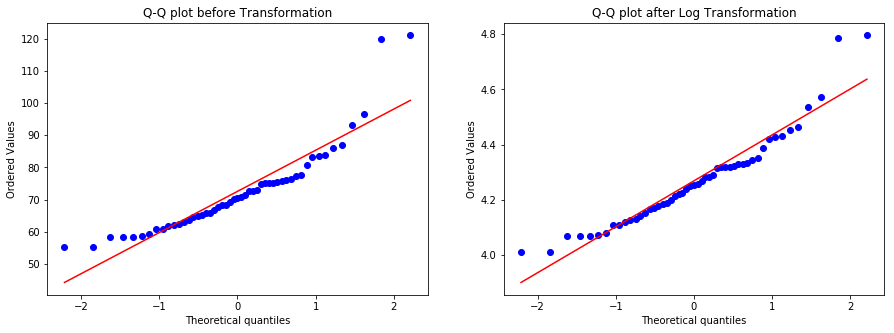

In [26]:
plt.subplots(1, 2, figsize=(15, 5))

plt.subplot(1, 2, 1)
probplot(df_features_final.loc[df_features_final['mouse_details_strain']=='PO', 'velocity_open_towards_middle_average_speed_active'], dist="norm", plot=pylab)
plt.title("Q-Q plot before Transformation")

plt.subplot(1, 2, 2)
probplot(np.log(df_features_final.loc[df_features_final['mouse_details_strain']=='PO', 'velocity_open_towards_middle_average_speed_active']), dist="norm", plot=pylab)
plt.title("Q-Q plot after Log Transformation")

plt.show()

#Outliers clearly seen!


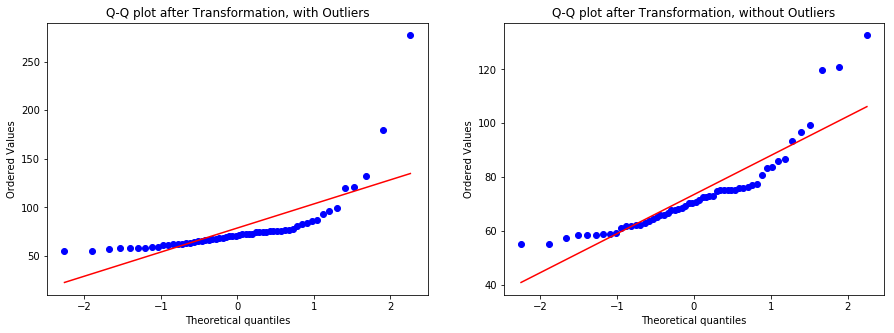

In [83]:
plt.subplots(1, 2, figsize=(15, 5))

plt.subplot(1, 2, 1)
probplot(df_bwpo.loc[(df_bwpo['mouse_details_strain']=='PO')&(df_bwpo['velocity_open_towards_middle_average_speed_active']!=0),
                     'velocity_open_towards_middle_average_speed_active'].dropna(), dist="norm", plot=pylab)
plt.title("Q-Q plot after Transformation, with Outliers")

plt.subplot(1, 2, 2)
probplot(sorted(df_bwpo.loc[(df_bwpo['mouse_details_strain']=='PO')&(df_bwpo['velocity_open_towards_middle_average_speed_active']!=0),
                     'velocity_open_towards_middle_average_speed_active'].dropna())[:-2], dist="norm", plot=pylab)
plt.title("Q-Q plot after Transformation, without Outliers")

plt.show()

In [28]:
#p-values of normality test (higher the p value, higher is the probability of the underlying distribution being Normal)
print(shapiro(df_features_final.loc[df_features_final['mouse_details_strain']=='PO', 'velocity_open_towards_middle_average_speed_active'])[1])
print(shapiro(np.log(sorted(df_features_final.loc[df_features_final['mouse_details_strain']=='PO', 'velocity_open_towards_middle_average_speed_active'])[:-2]))[1])

#Outlier removal clearly helped!


9.785273505258374e-06
0.5203026533126831


In [35]:
#p-values of normality test (higher the p value, higher is the probability of the underlying distribution being Normal)
print(shapiro(df_features_final.loc[df_features_final['mouse_details_strain']=='PO', 'velocity_open_towards_outside_average_speed_active'])[1])
print(shapiro(np.log(sorted(df_features_final.loc[df_features_final['mouse_details_strain']=='PO', 'velocity_open_towards_outside_average_speed_active'])[:-2]))[1])

#Outlier removal clearly helped!


1.2264216309176845e-08
0.46230748295783997


## Other Issues

'fraction_in_arms_closed' - different distributions for BW and PO - can't do any transformation

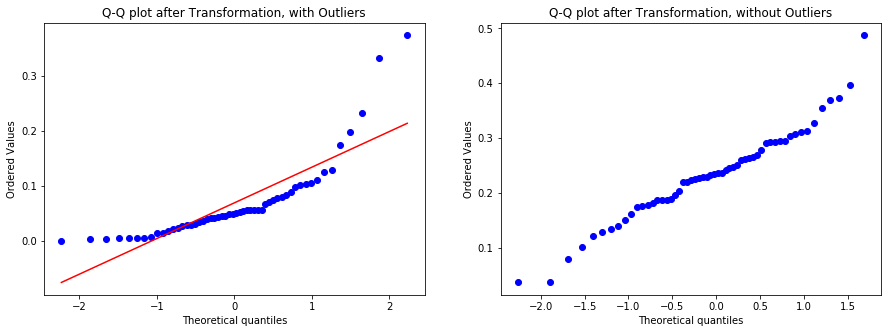

In [135]:
plt.subplots(1, 2, figsize=(15, 5))

plt.subplot(1, 2, 1)
probplot(df_bwpo.loc[df_bwpo['mouse_details_strain']=='BW', 'fraction_in_arms_open'], dist="norm", plot=pylab)
plt.title("Q-Q plot after Transformation, with Outliers")

plt.subplot(1, 2, 2)
probplot(df_bwpo.loc[df_bwpo['mouse_details_strain']=='PO', 'fraction_in_arms_open'], dist="norm", plot=pylab)
plt.title("Q-Q plot after Transformation, without Outliers")

plt.show()

In [112]:
np.array(final_features)[stats_test_p<np.full(len(stats_test_p), 0.05)]

array(['fraction_in_arms_closed', 'fraction_in_arms_open-arms',
       'mouse_length', 'peeking_average_length_total',
       'peeking_median_length_total', 'rest_fraction_all_arms',
       'rest_fraction_closed_arms',
       'safety_and_rest_fraction_closed_arms',
       'turning_preferences_fraction_left',
       'turning_preferences_fraction_right',
       'turning_preferences_fraction_straight',
       'velocity_closed_towards_middle_median_speed',
       'velocity_closed_towards_outside_median_speed',
       'velocity_closed_towards_outside_median_speed_active',
       'velocity_open_towards_middle_median_speed_active',
       'velocity_open_towards_outside_median_speed',
       'velocity_open_towards_outside_median_speed_active'], dtype='<U51')

# Two Factor Analysis

In [155]:
# To determine if ANOVA conditions are satisfied

def anova_conditions(df, features, alpha_normal=0.05, alpha_significance=0.05):

    ''' significance(df_features, features, alpha_normal=0.05, alpha_significance=0.05)
    Input: DataFrame of aggregated mice features, features, alpha levels
    Output: Normality_results, Feature significance, p-values'''
    
    #Initiate empty lists for results
    normal_count = [] #Number of normal dist.
#     normality_panova = [] #Tuple of normality test results
    std=[] #Levene's test
    std_log=[]

    for feature in features:
        
        sample1= df.loc[(df['mouse_details_strain']== 'BW') & (df['mouse_details_sex'] == 'M')
                        & (df[feature]!=0), feature].dropna()
        sample2= df.loc[(df['mouse_details_strain']== 'BW') & (df['mouse_details_sex'] == 'F')
                        &(df[feature]!=0), feature].dropna() 
        sample3= df.loc[(df['mouse_details_strain']== 'PO') & (df['mouse_details_sex'] == 'M')
                        &(df[feature]!=0), feature].dropna()
        sample4= df.loc[(df['mouse_details_strain']== 'PO') & (df['mouse_details_sex'] == 'F')
                        &(df[feature]!=0), feature].dropna()
        
        #Do a Normality test and store p value
        norm1 = shapiro(sample1)[1]
        norm2 = shapiro(sample2)[1]
        norm3 = shapiro(sample3)[1]
        norm4 = shapiro(sample4)[1]
        
        norm_original = np.sum(np.array([norm1, norm2, norm3, norm4])>0.05)
        norm_log = np.sum(np.array([shapiro(np.log(sample1))[1], shapiro(np.log(sample2))[1], 
                                   shapiro(np.log(sample3))[1], shapiro(np.log(sample4))[1]])>0.05)
        norm_sq = np.sum(np.array([np.square(shapiro(sample1))[1], np.square(shapiro(sample2))[1], 
                                  np.square(shapiro(sample3))[1], np.square(shapiro(sample4)[1])])>0.05)
        
        normal_count.append((norm_original, norm_log, norm_sq))
        std.append(levene(sample1, sample2, sample3, sample4)[1])
        
        std_log.append(levene(np.log(sample1), np.log(sample2), np.log(sample3), np.log(sample4))[1])
        
    return normal_count, std, std_log#, significance, stats_test_p

In [156]:
normal_count, std, std_log = anova_conditions(df_bwpo, features=final_features)

In [148]:
final_features

['fraction_in_arms_closed',
 'fraction_in_arms_middle',
 'fraction_in_arms_open',
 'mouse_length',
 'peeking_average_length_total',
 'peeking_fraction_total',
 'peeking_median_length_total',
 'rest_fraction_all_arms',
 'rest_fraction_closed_arms',
 'rest_fraction_open_arms',
 'safety_and_rest_fraction_closed_arms',
 'safety_fraction_closed_arms',
 'turning_preferences_fraction_back',
 'turning_preferences_fraction_left',
 'turning_preferences_fraction_right',
 'turning_preferences_fraction_straight',
 'velocity_closed_towards_middle_average_speed_active',
 'velocity_closed_towards_middle_median_speed_active',
 'velocity_closed_towards_outside_average_speed_active',
 'velocity_closed_towards_outside_median_speed_active',
 'velocity_open_towards_middle_average_speed_active',
 'velocity_open_towards_middle_median_speed_active',
 'velocity_open_towards_outside_average_speed_active',
 'velocity_open_towards_outside_median_speed_active']

In [157]:
normal_count

[(3, 3, 3),
 (3, 2, 3),
 (3, 1, 3),
 (1, 1, 1),
 (0, 3, 0),
 (1, 2, 1),
 (2, 4, 1),
 (4, 4, 2),
 (4, 4, 4),
 (4, 2, 3),
 (4, 3, 3),
 (2, 2, 2),
 (2, 2, 0),
 (3, 4, 3),
 (3, 3, 2),
 (3, 3, 1),
 (3, 4, 0),
 (3, 4, 2),
 (3, 4, 2),
 (1, 3, 0),
 (0, 0, 0),
 (1, 2, 1),
 (0, 2, 0),
 (2, 3, 1)]

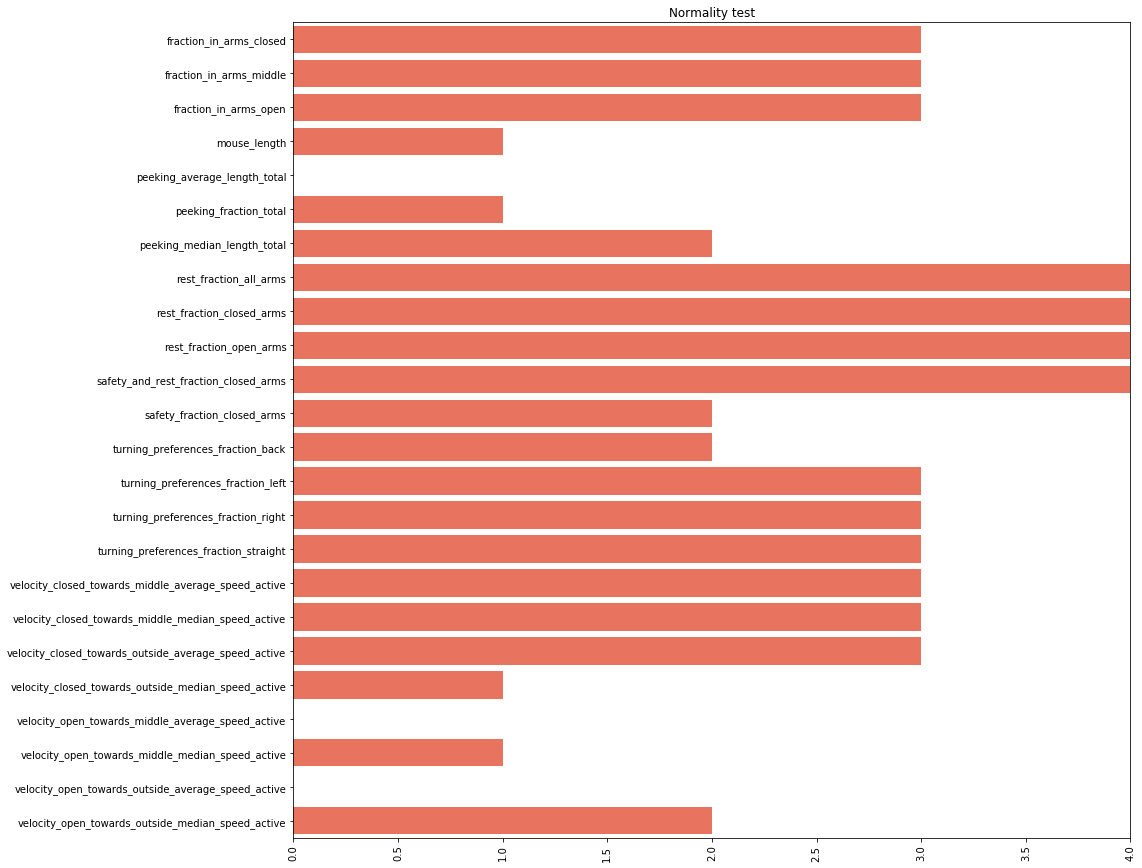

In [66]:
plt.figure(figsize=(15, 15))
plt.title("Normality test")
sns.barplot(x=[norm[0] for norm in normal_count], y=final_features, color='tomato')
plt.xticks(rotation= 90)
plt.xlim(0, 4)
plt.show()

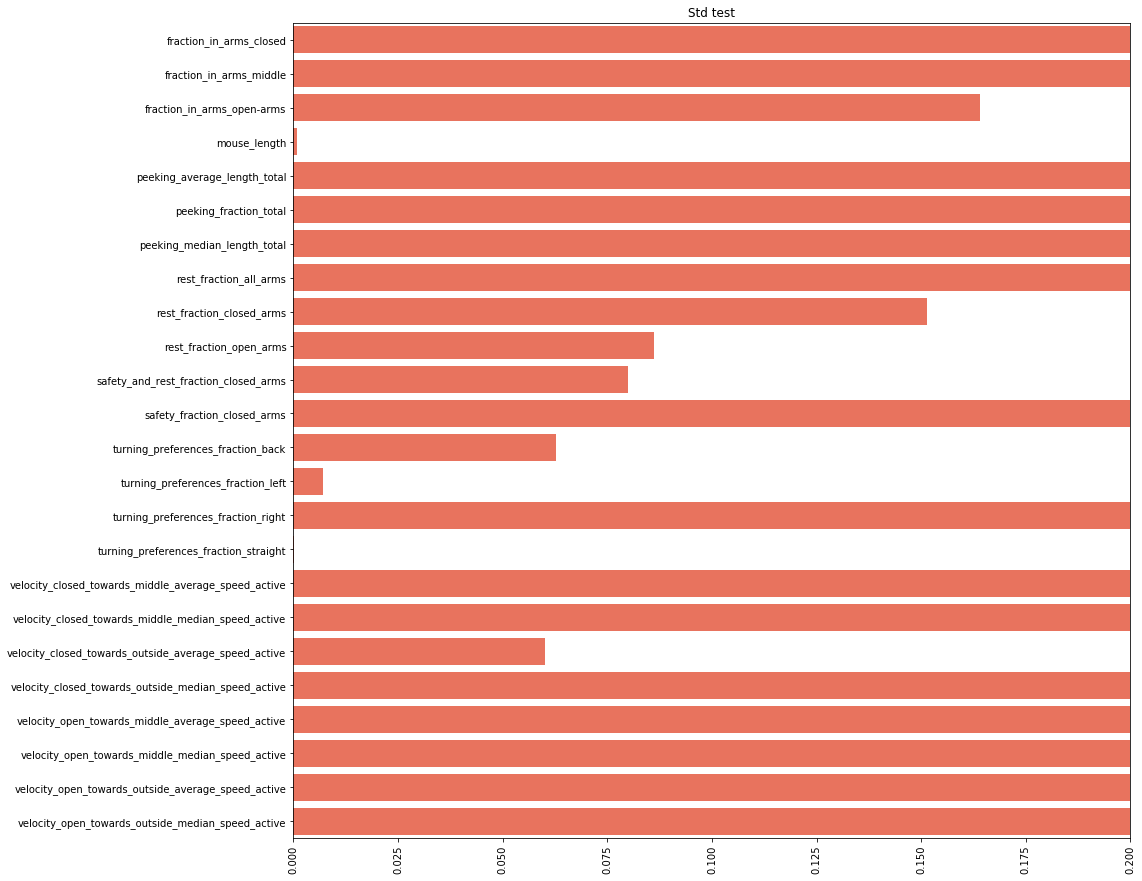

In [262]:
plt.figure(figsize=(15, 15))
plt.title("Std test")
sns.barplot(x=std, y=final_features, color='tomato')
plt.xticks(rotation= 90)
plt.xlim(0,0.2)
plt.show()

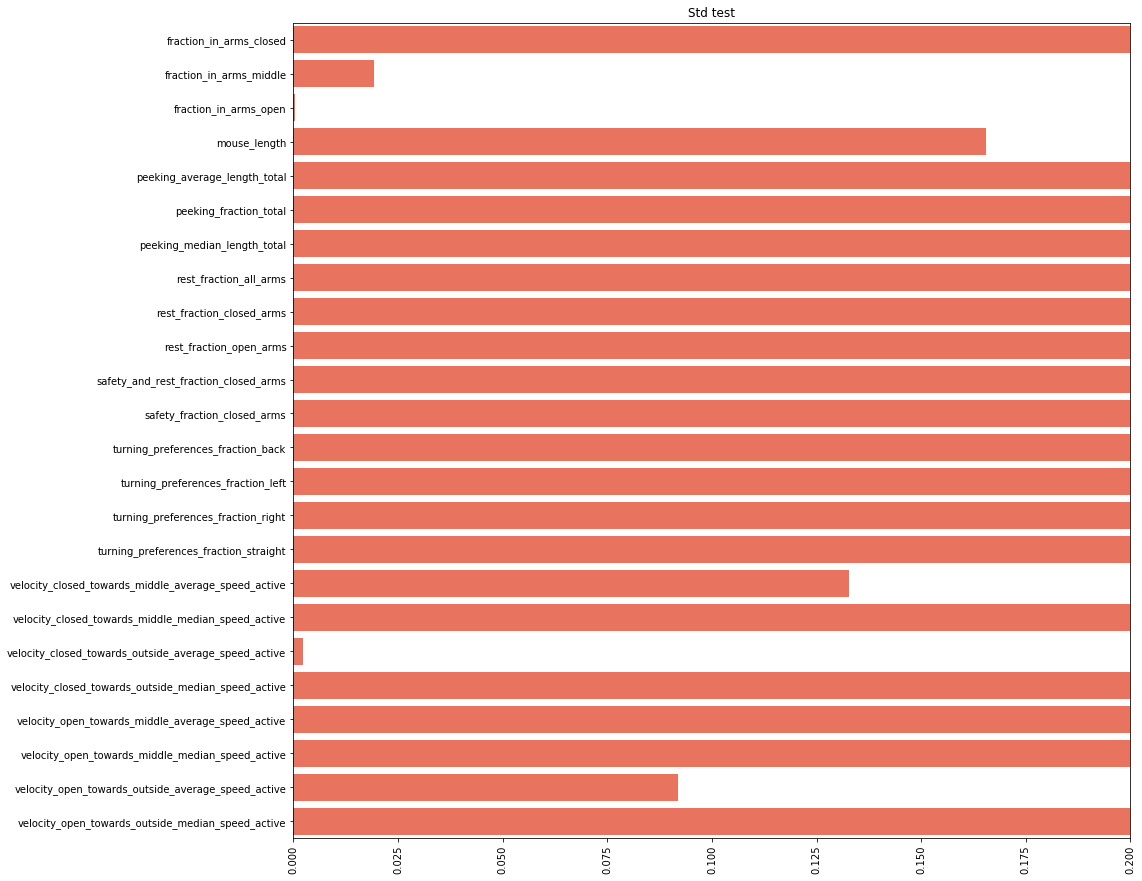

In [158]:
plt.figure(figsize=(15, 15))
plt.title("Std test")
sns.barplot(x=std_log, y=final_features, color='tomato')
plt.xticks(rotation= 90)
plt.xlim(0,0.2)
plt.show()

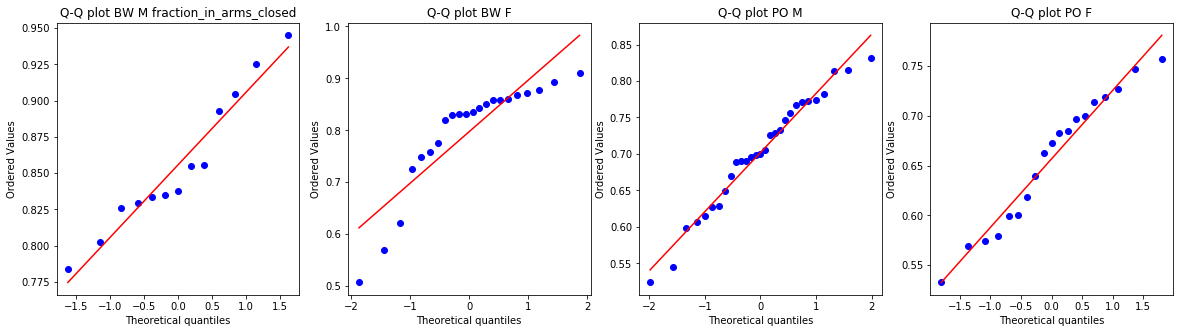

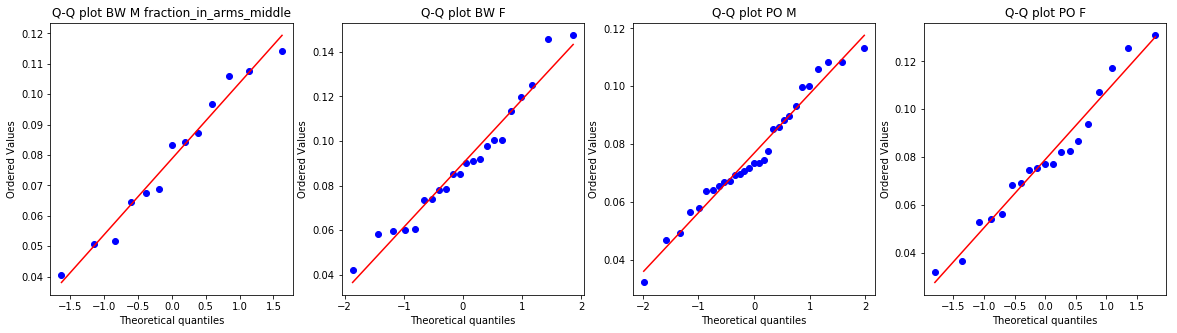

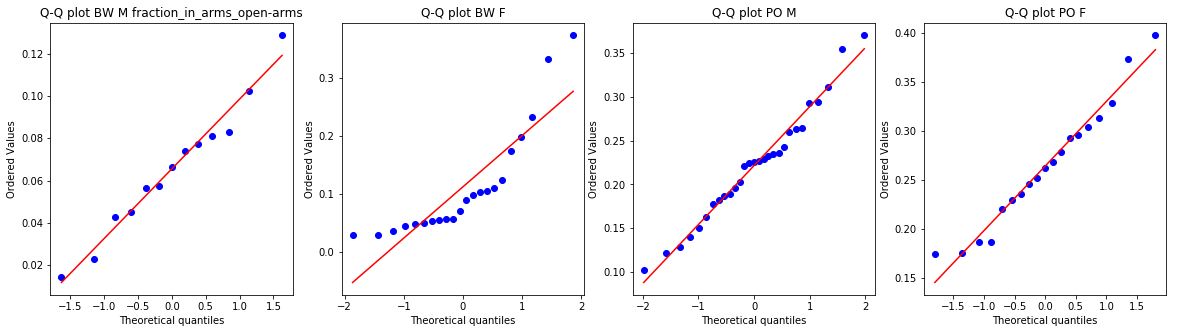

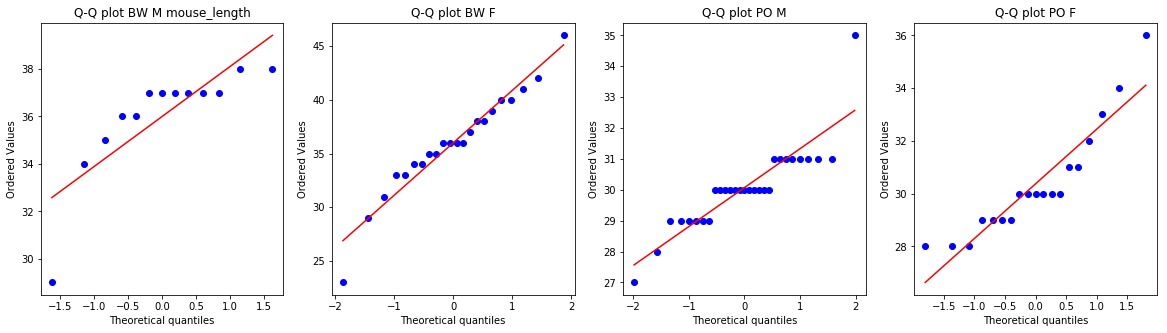

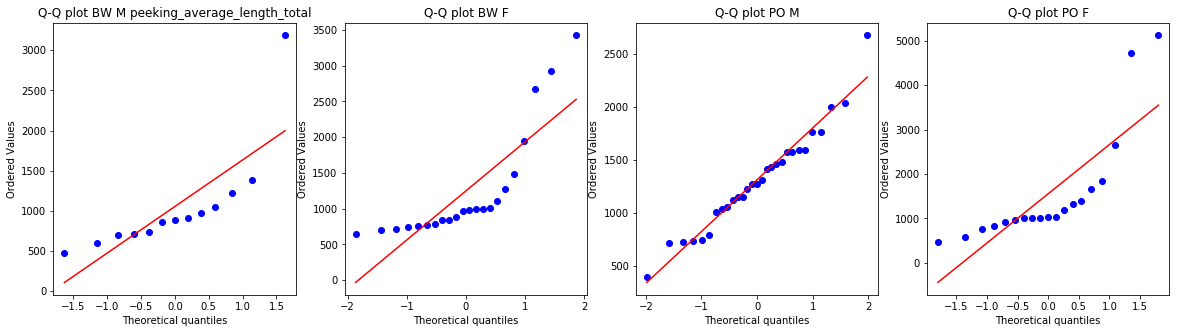

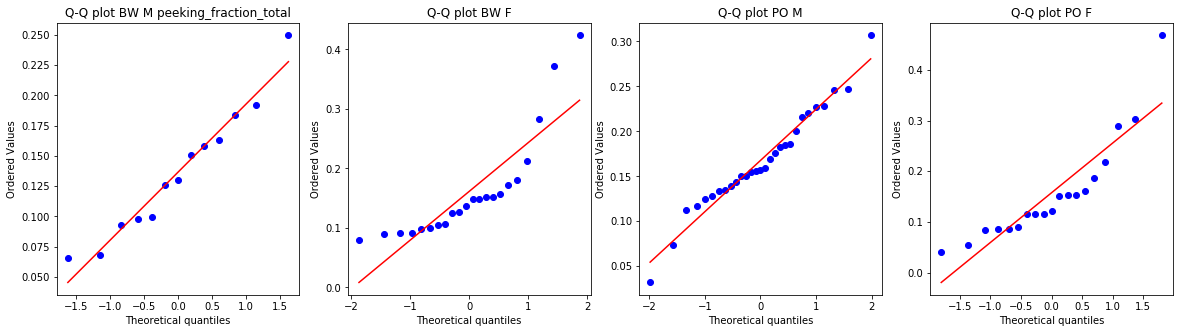

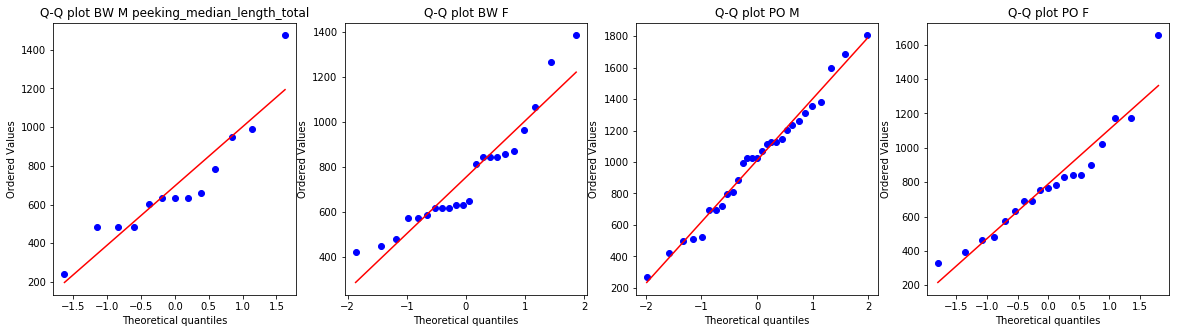

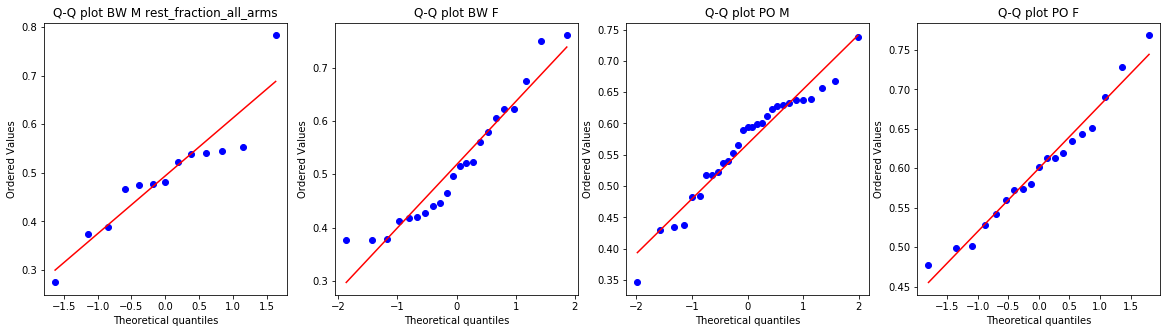

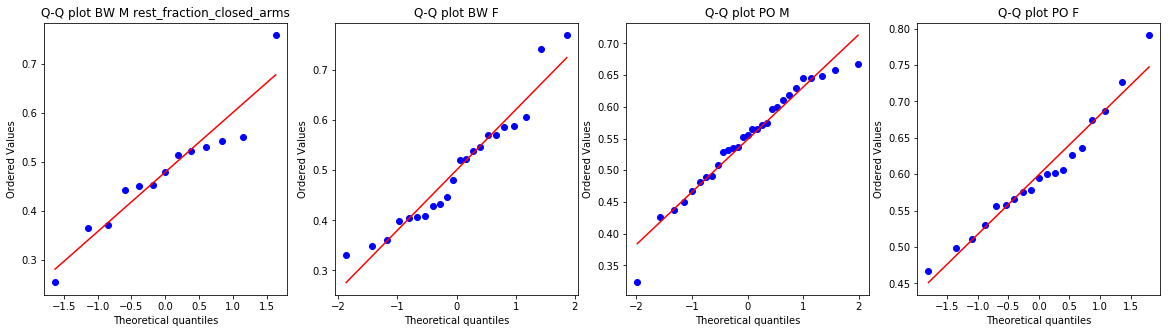

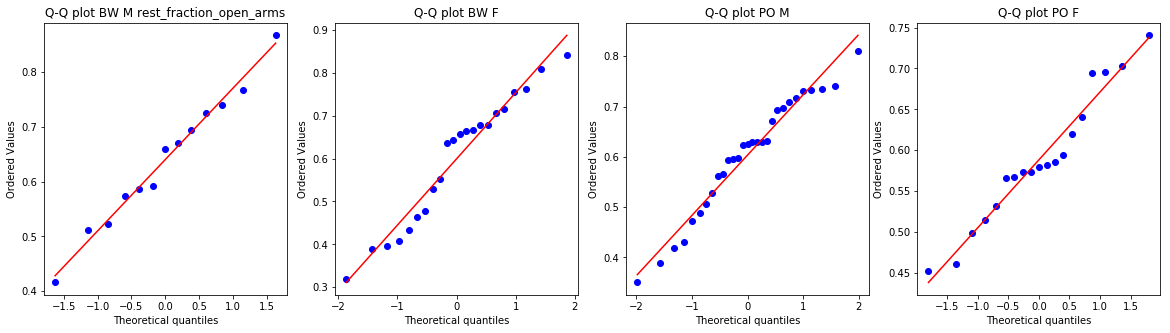

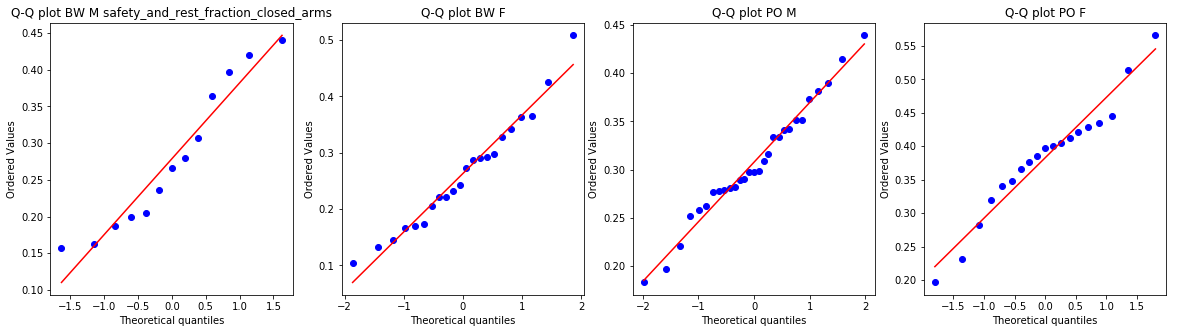

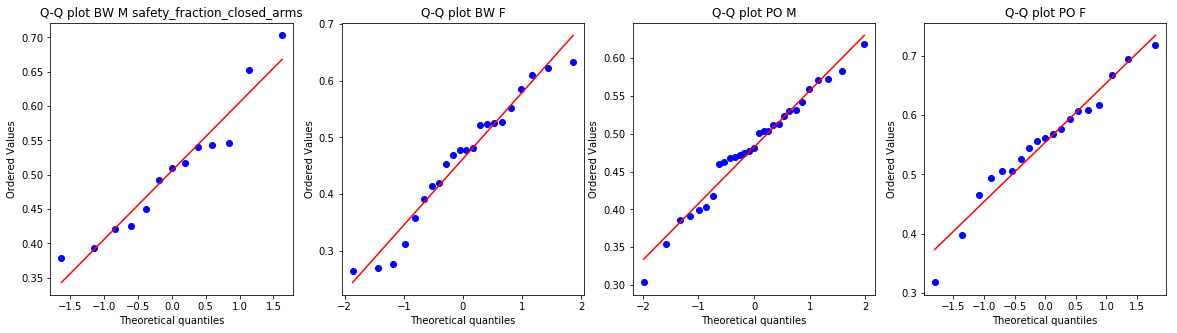

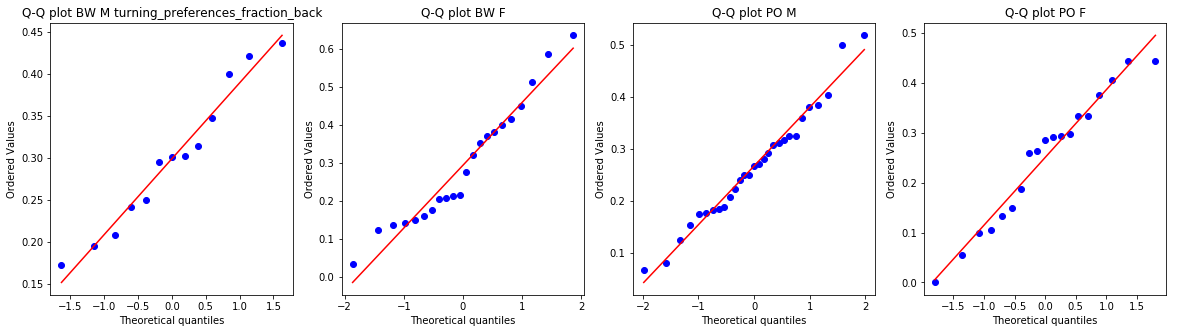

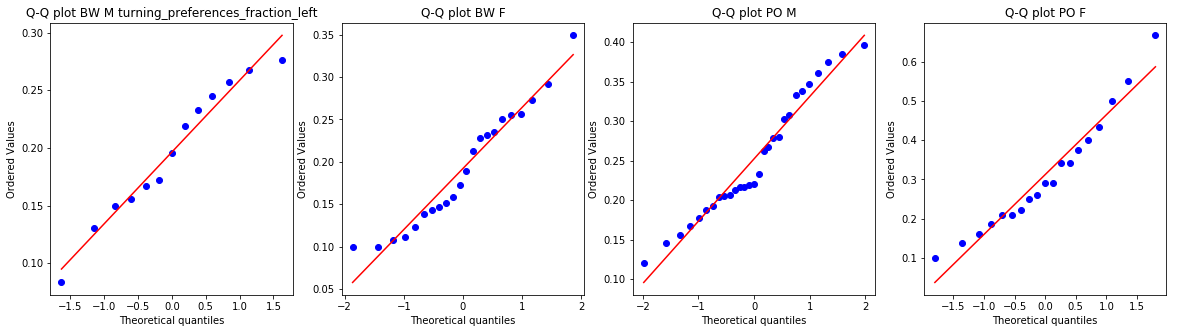

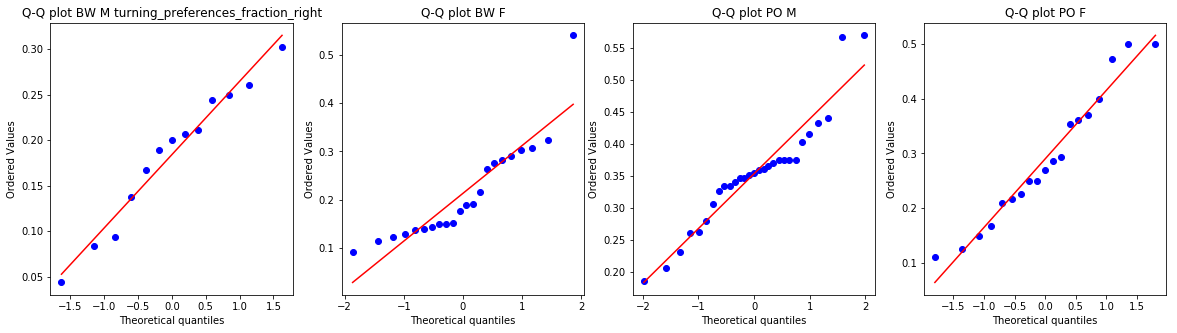

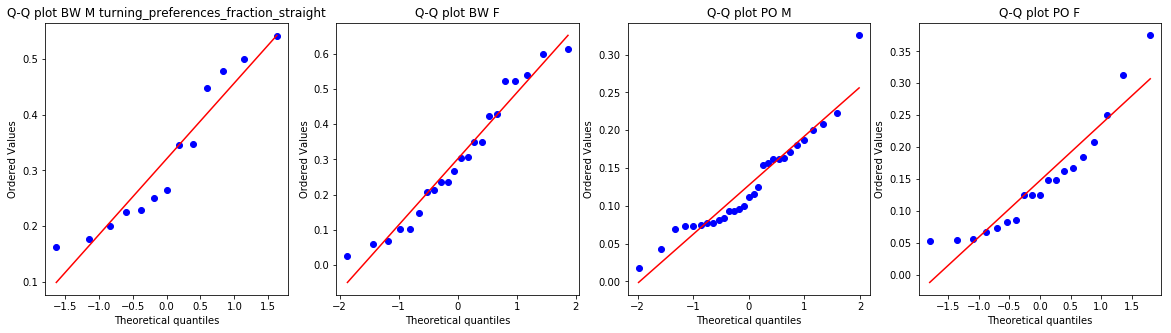

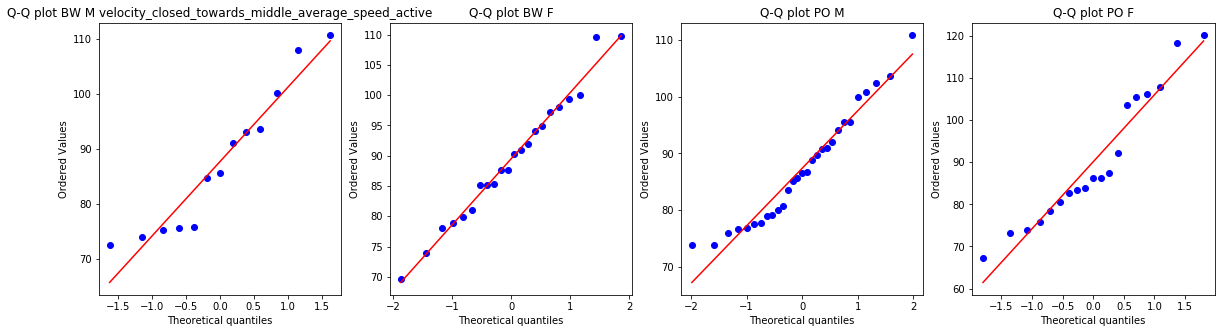

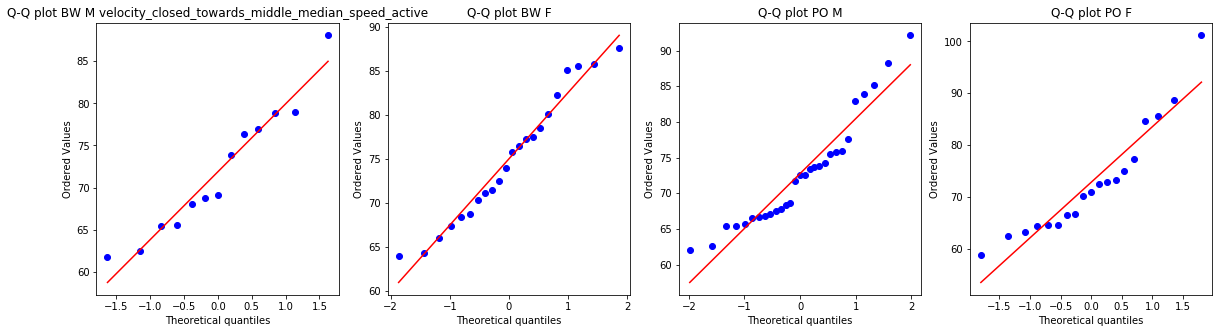

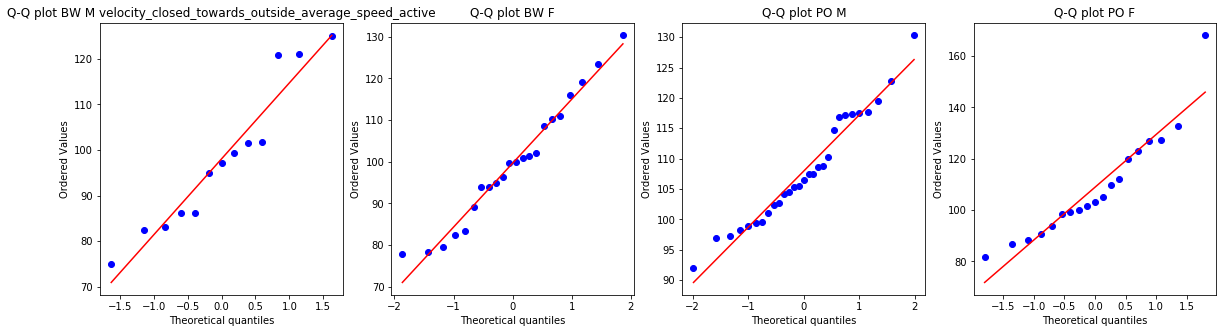

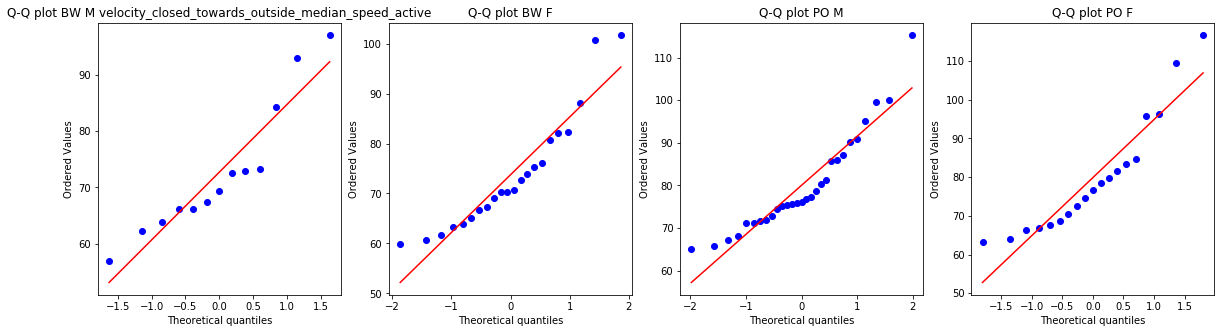

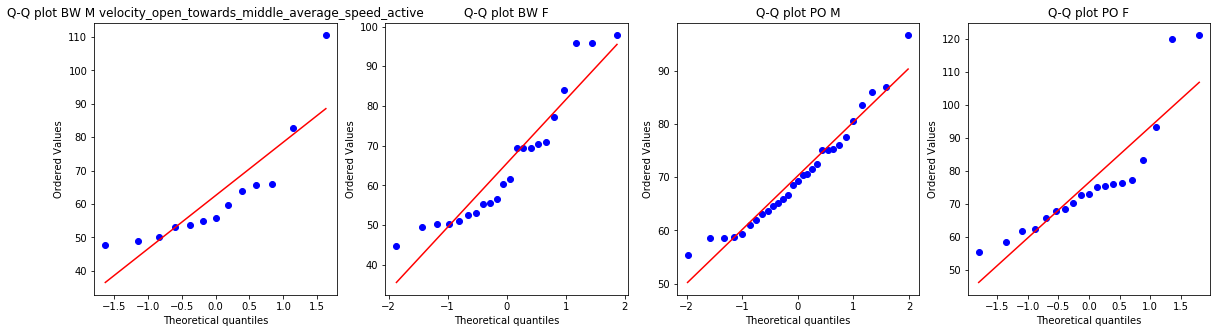

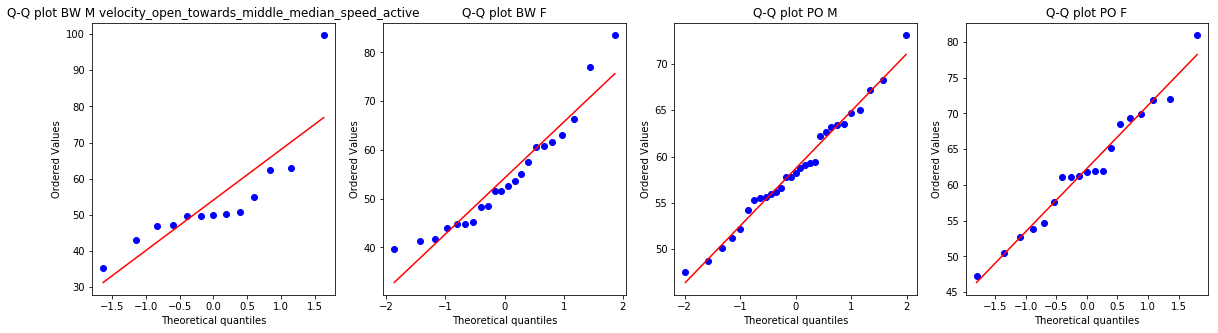

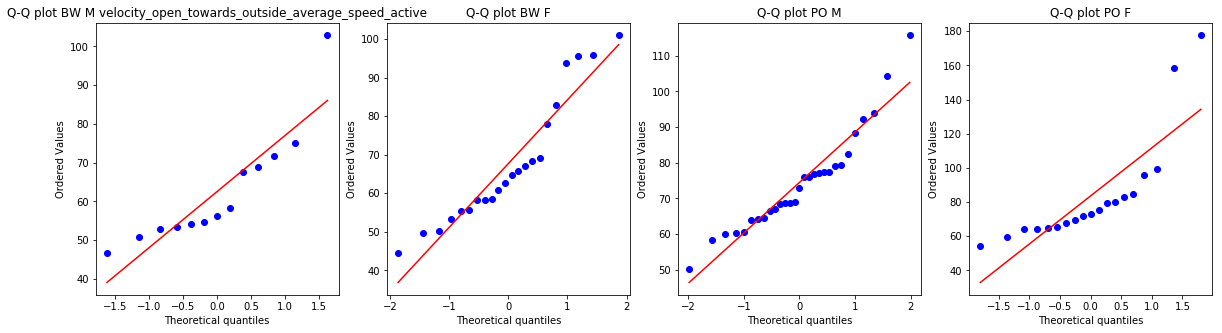

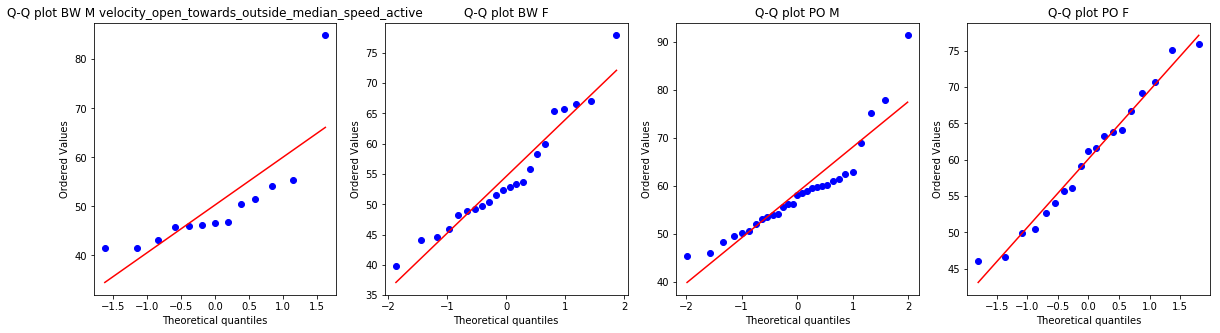

In [261]:
i=0
for feature in final_features:

    plt.subplots(1, 4, figsize=(20, 5))

    plt.subplot(1, 4, 1)
    probplot(df_bwpo.loc[(df_bwpo['mouse_details_strain']=='BW') &
                                    (df_bwpo['mouse_details_sex']=='M'), feature], dist="norm", plot=pylab)
    plt.title("Q-Q plot BW M "+ feature)

    plt.subplot(1, 4, 2)
    probplot(df_bwpo.loc[(df_bwpo['mouse_details_strain']=='BW') &
                                    (df_bwpo['mouse_details_sex']=='F'), feature], dist="norm", plot=pylab)
    plt.title("Q-Q plot BW F")

    plt.subplot(1, 4, 3)
    probplot(df_bwpo.loc[(df_bwpo['mouse_details_strain']=='PO') &
                                    (df_bwpo['mouse_details_sex']=='M'), feature], dist="norm", plot=pylab)
    plt.title("Q-Q plot PO M")

    plt.subplot(1, 4, 4)
    probplot(df_bwpo.loc[(df_bwpo['mouse_details_strain']=='PO') &
                                    (df_bwpo['mouse_details_sex']=='F'), feature], dist="norm", plot=pylab)
    plt.title("Q-Q plot PO F")
             
    plt.show()

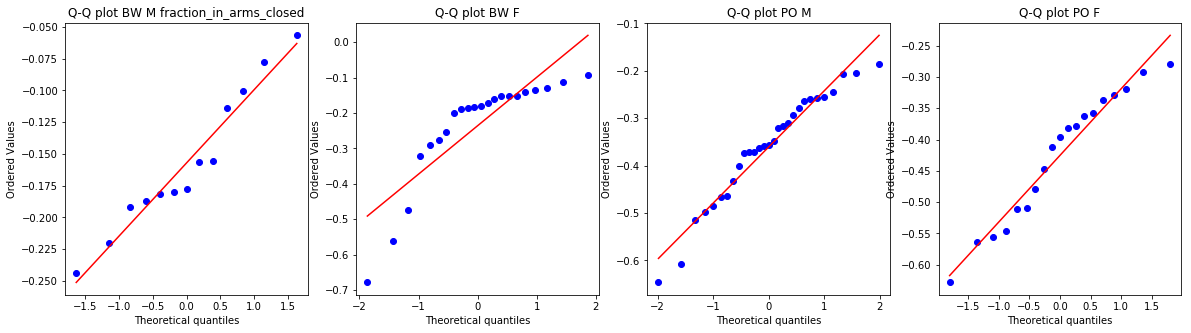

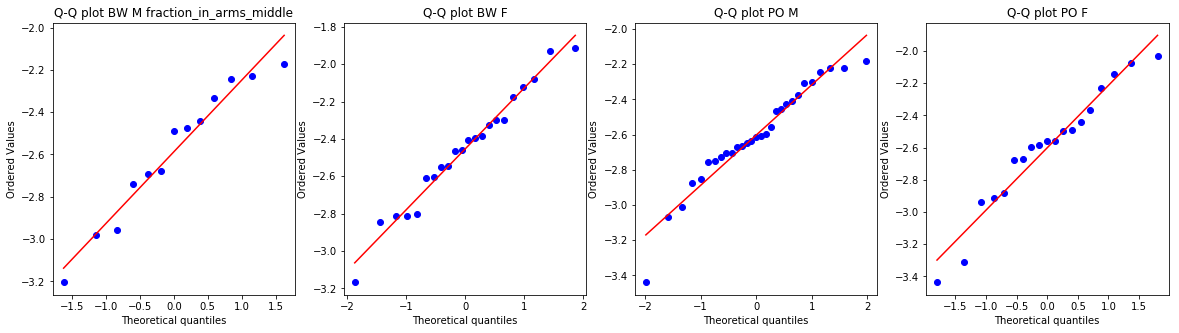

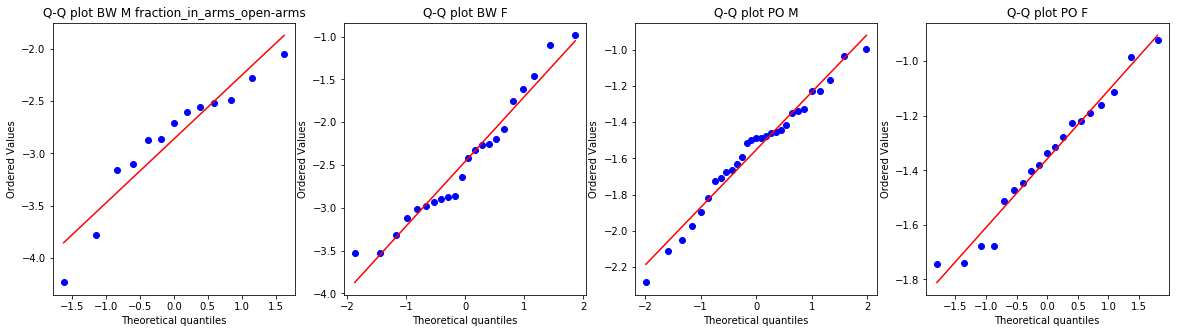

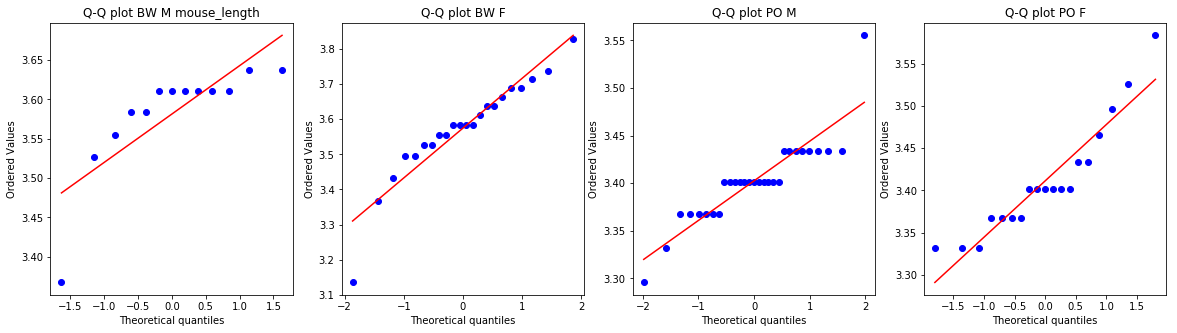

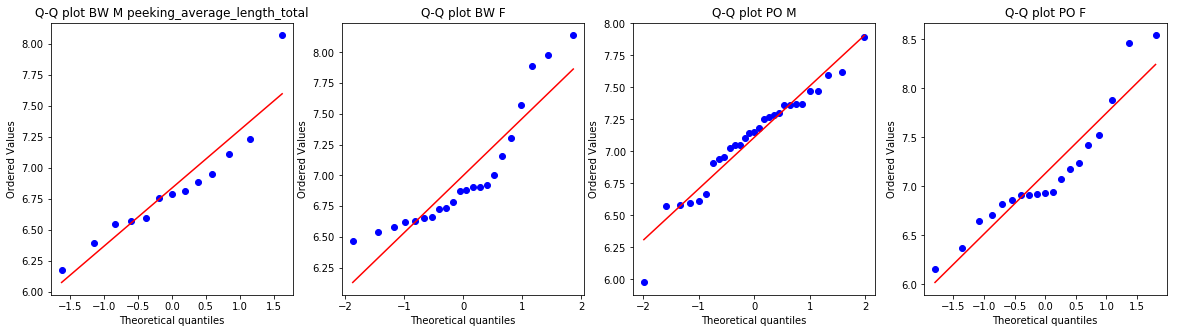

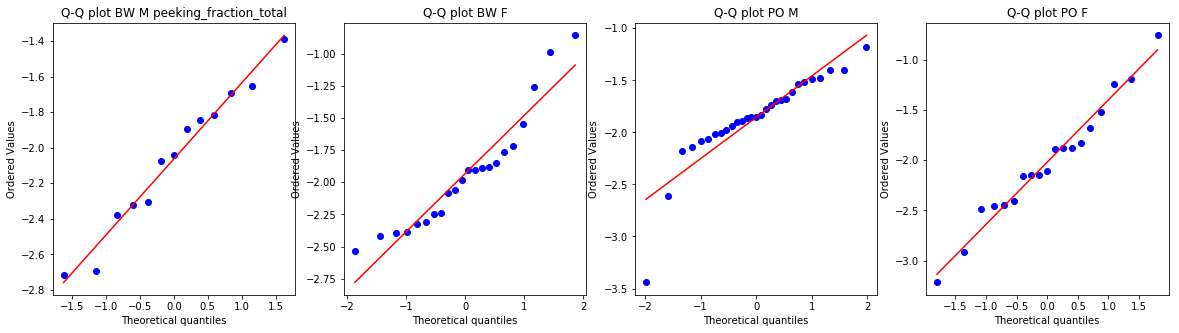

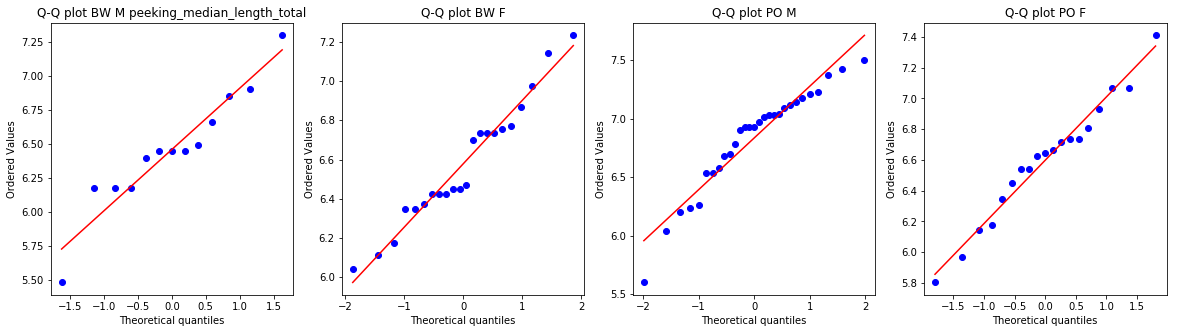

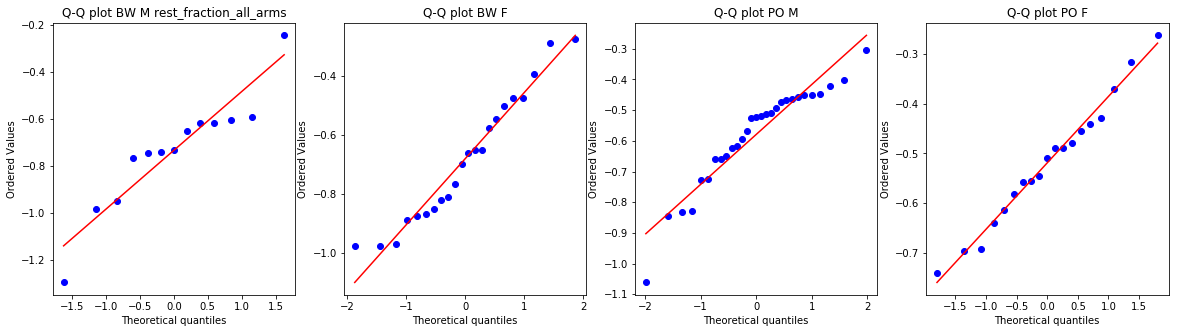

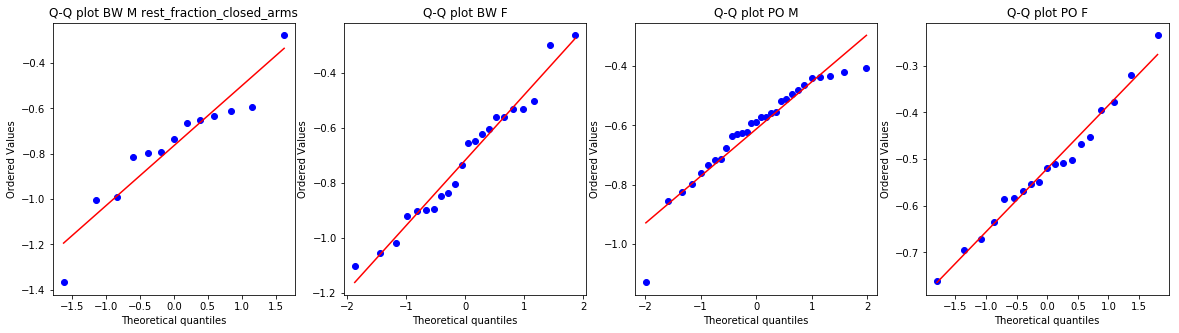

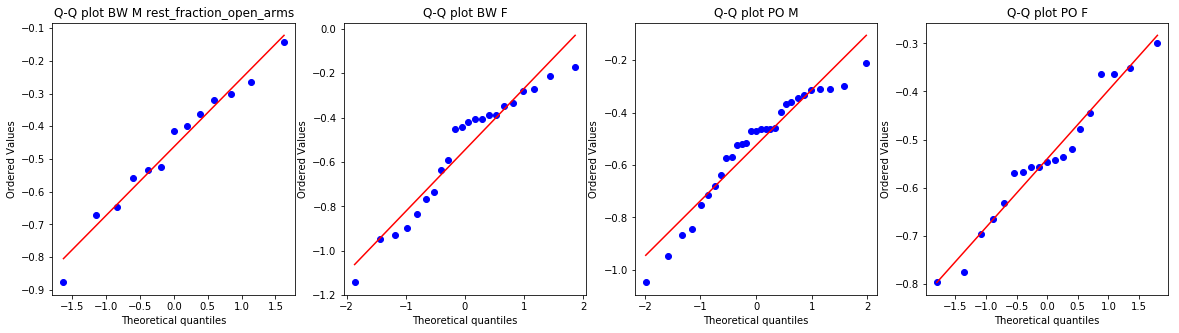

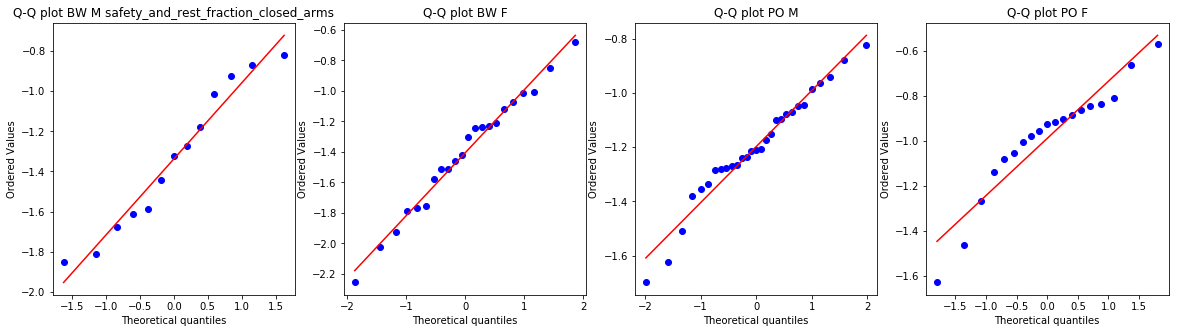

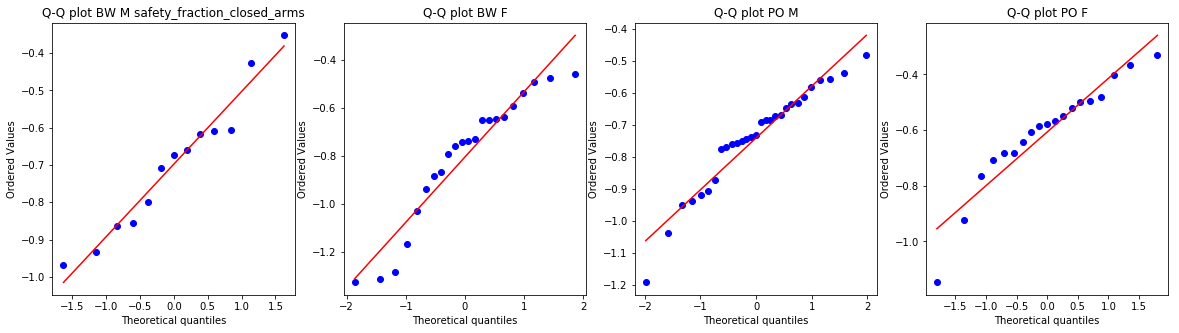

/Users/srinidhi/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log
/Users/srinidhi/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:2320: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


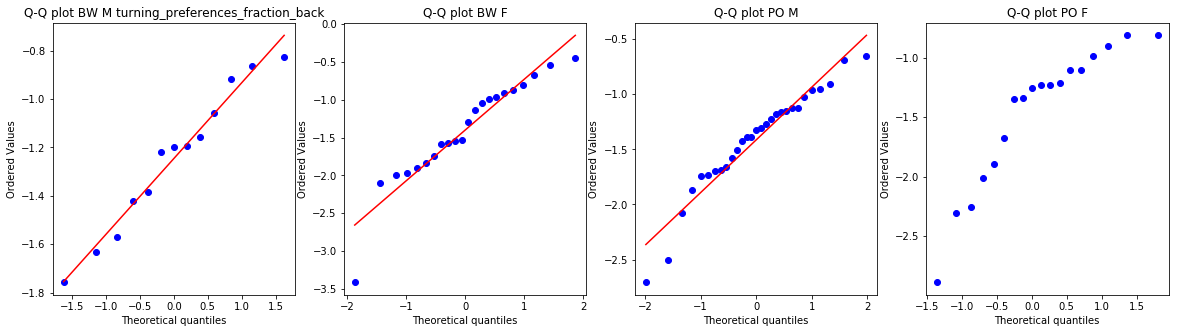

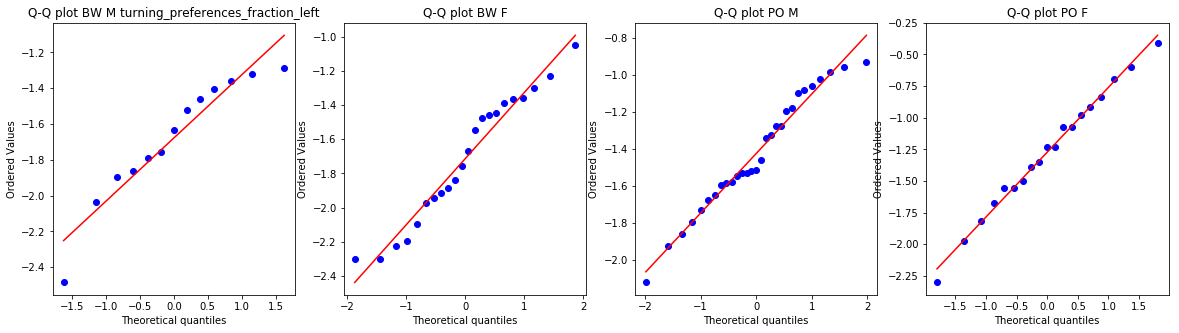

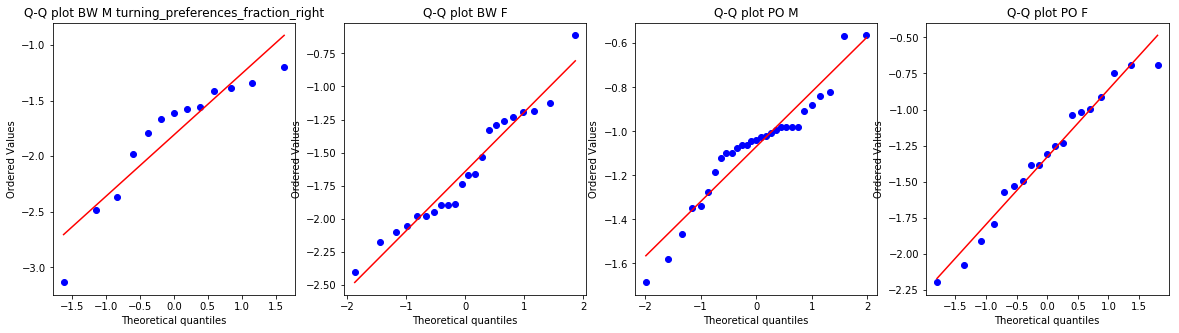

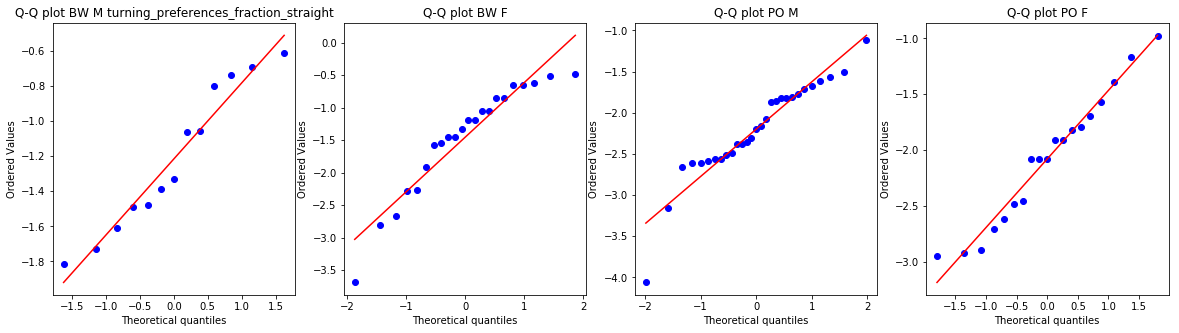

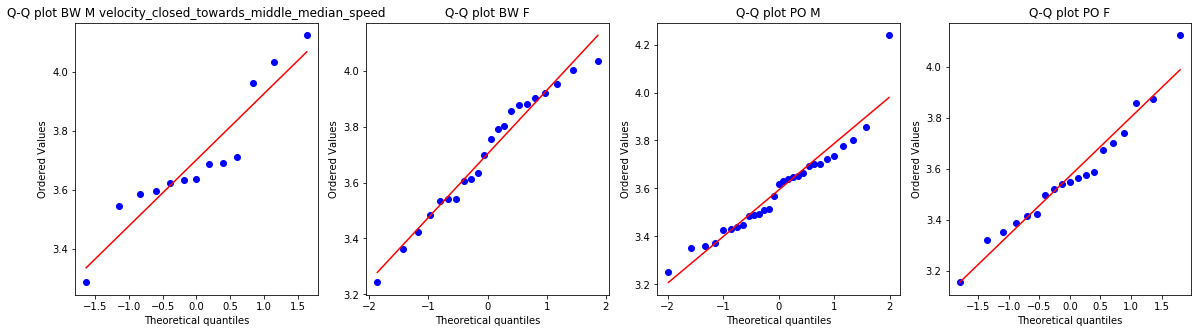

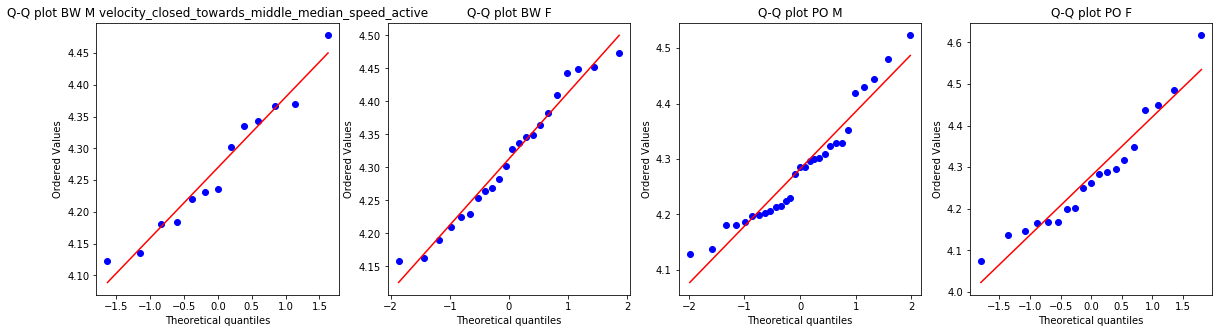

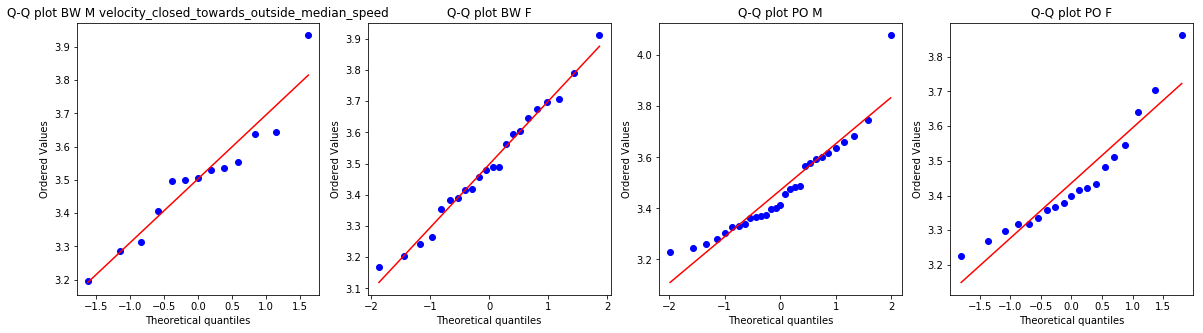

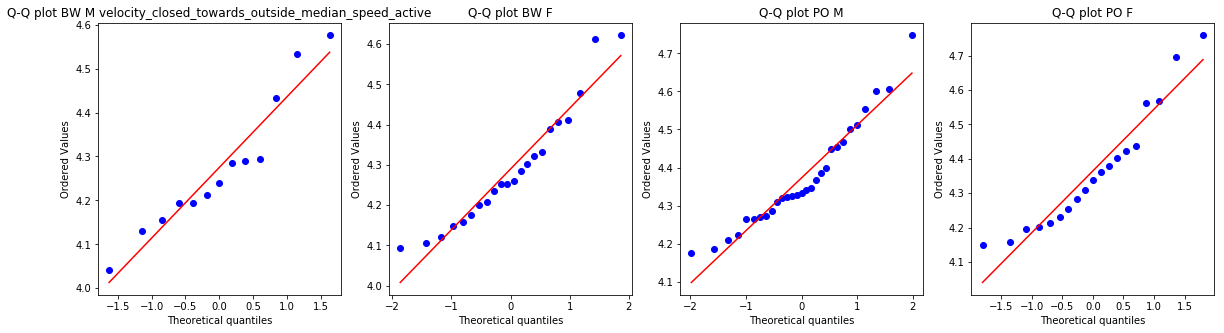

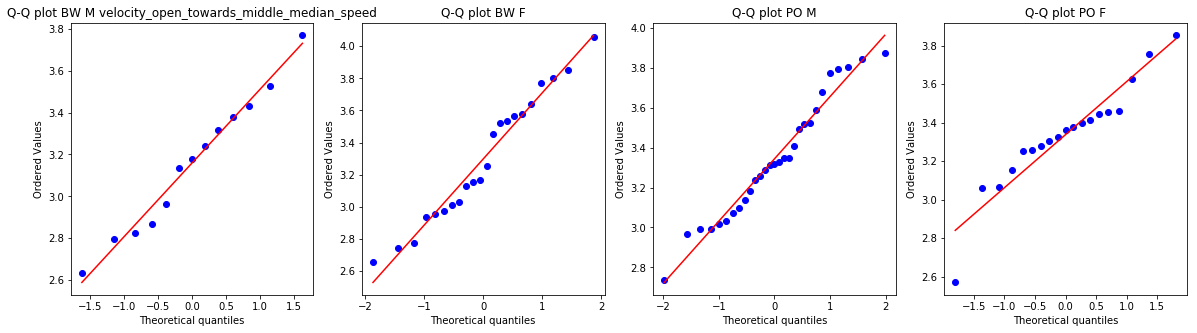

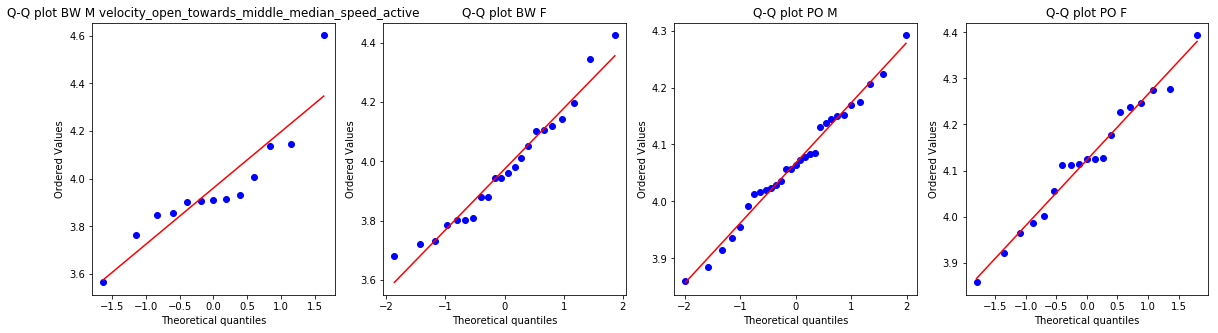

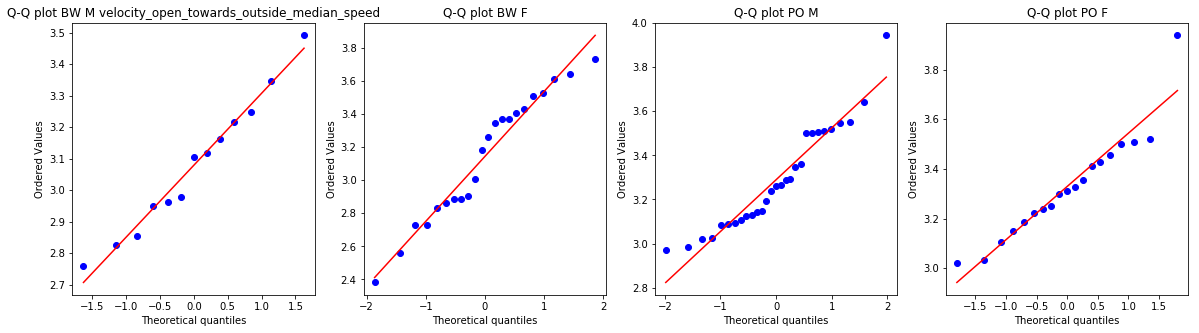

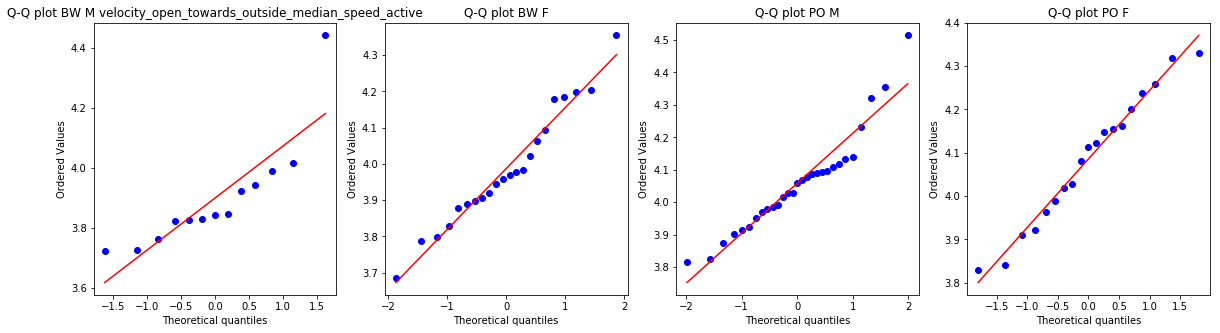

In [178]:
i=0
for feature in final_features:

    plt.subplots(1, 4, figsize=(20, 5))

    plt.subplot(1, 4, 1)
    probplot(np.log(df_features_final.loc[(df_features_final['mouse_details_strain']=='BW') &
                                    (df_features_final['mouse_details_sex']=='M'), feature]), dist="norm", plot=pylab)
    plt.title("Q-Q plot BW M "+ feature)

    plt.subplot(1, 4, 2)
    probplot(np.log(df_features_final.loc[(df_features_final['mouse_details_strain']=='BW') &
                                    (df_features_final['mouse_details_sex']=='F'), feature]), dist="norm", plot=pylab)
    plt.title("Q-Q plot BW F")

    plt.subplot(1, 4, 3)
    probplot(np.log(df_features_final.loc[(df_features_final['mouse_details_strain']=='PO') &
                                    (df_features_final['mouse_details_sex']=='M'), feature]), dist="norm", plot=pylab)
    plt.title("Q-Q plot PO M")

    plt.subplot(1, 4, 4)
    probplot(np.log(df_features_final.loc[(df_features_final['mouse_details_strain']=='PO') &
                                    (df_features_final['mouse_details_sex']=='F'), feature]), dist="norm", plot=pylab)
    plt.title("Q-Q plot PO F")
             
    plt.show()

In [144]:
# ANOVA

def anova(df, features, alpha_significance=0.05):

    ''' significance(df_features, features, alpha_normal=0.05, alpha_significance=0.05)
    Input: DataFrame of aggregated mice features, features, alpha levels
    Output: Normality_results, Feature significance, p-values'''
    
    #Initiate empty lists for results

    significance_species= []
    significance_sex= []
    significance_species_sex= []
    
    for feature in features:
        
        data = df.loc[(df[feature]!=0) ,['mouse_details_sex', 'mouse_details_strain', feature]].dropna()
        data[feature] = np.log(data[feature])
        model = ols(feature+' ~ C(mouse_details_strain, Sum)*C(mouse_details_sex, Sum)', data=data).fit()
        table = sm.stats.anova_lm(model, typ=2) # Type 2 Anova DataFrame

        significance_species.append(table['PR(>F)'][0])
        significance_sex.append(table['PR(>F)'][1])
        significance_species_sex.append(table['PR(>F)'][2])
        
    return significance_species, significance_sex, significance_species_sex#, significance, stats_test_p

In [146]:
anova_species_log, anova_sex_log, anova_species_sex_log = anova(df_bwpo, final_features)

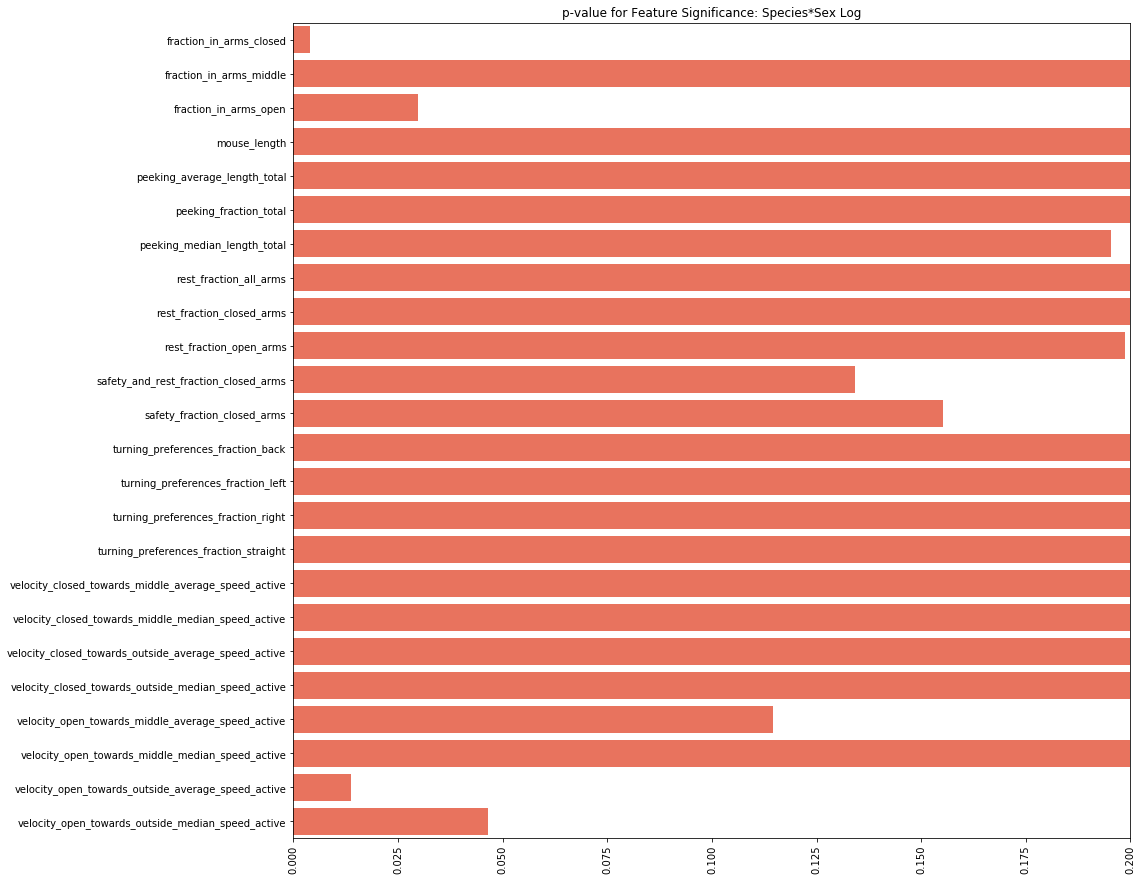

In [160]:
plt.figure(figsize=(15, 15))
plt.title("p-value for Feature Significance: Species*Sex Log")
sns.barplot(x=anova_sex_log, y=final_features, color='tomato')
plt.xticks(rotation= 90)
plt.xlim(0, 0.2)
plt.show()

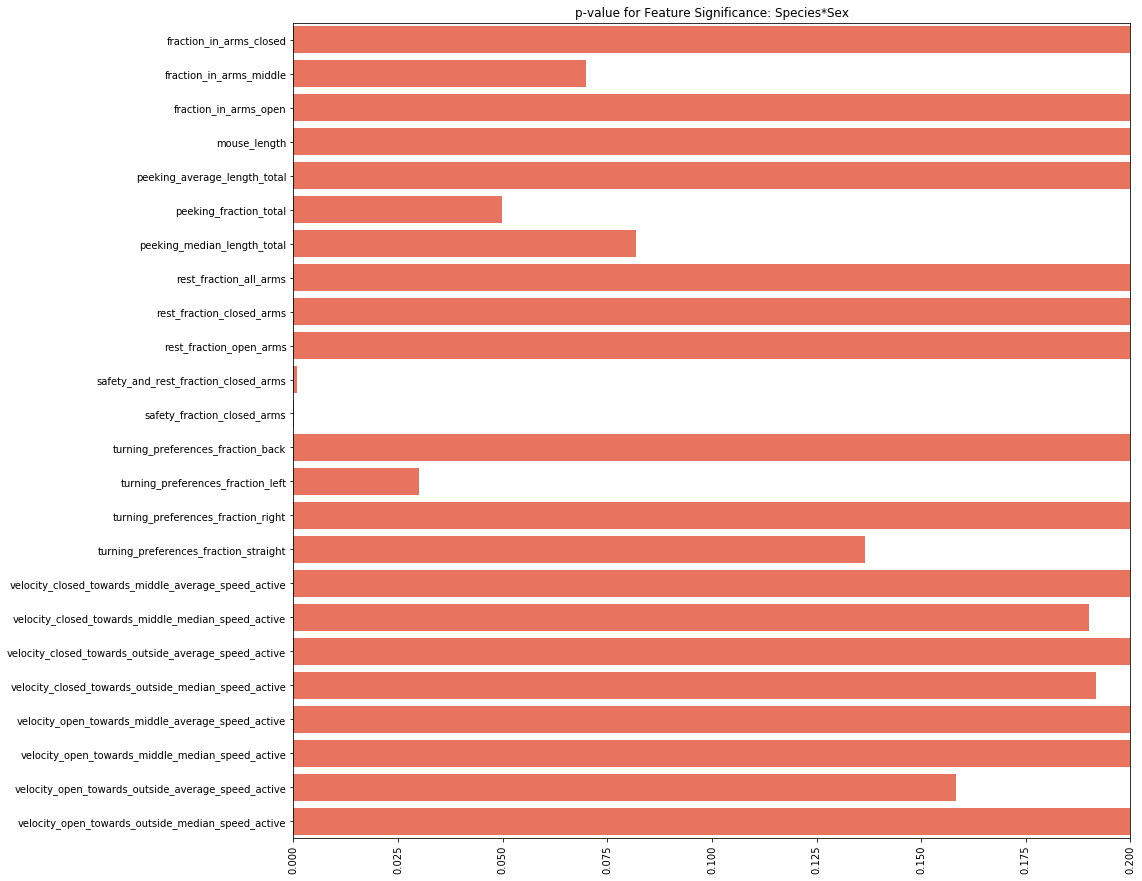

In [136]:
plt.figure(figsize=(15, 15))
plt.title("p-value for Feature Significance: Species*Sex")
sns.barplot(x=anova_species_sex, y=final_features, color='tomato')
plt.xticks(rotation= 90)
plt.xlim(0, 0.2)
plt.show()

In [164]:
df_bwpo.groupby(['mouse_details_strain', 'mouse_details_sex'])['velocity_open_towards_outside_average_speed_active'].mean()

mouse_details_strain  mouse_details_sex
BW                    F                    65.400408
                      M                    60.705625
PO                    F                    89.819984
                      M                    73.486559
Name: velocity_open_towards_outside_average_speed_active, dtype: float64

In [179]:
df_bwpo.groupby(['mouse_details_strain', 'mouse_details_sex'])['fraction_in_arms_closed'].mean()

mouse_details_strain  mouse_details_sex
BW                    F                    0.842421
                      M                    0.896130
PO                    F                    0.658749
                      M                    0.709610
Name: fraction_in_arms_closed, dtype: float64